In [1]:
import random
import pandas as pd
import numpy as np
from utils import *
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut,GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pygam import LogisticGAM, s, f, l
import warnings
warnings.filterwarnings("ignore")

# Vegetation Classification using Machine Learning

## Load Data

In [2]:
# Load all the classes into different Dataframes

class1 = pd.read_csv('data/Data_Class_1.csv')
class3 = pd.read_csv('data/Data_Class_3.csv')
class6 = pd.read_csv('data/Data_Class_6.csv')

## Descriptive Statistics

In [3]:
# Combine all classes into one dataset and view the top rows

data = pd.concat([class1, class3, class6], ignore_index=True)
data

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level,Soil_Type,Wilderness_Area,Vegetation_Type
0,41,2699,347,3,0,0,2096,213,234,159,6853,37.32,282.46,125.22,6.23,Type_20,Area_1,Type_1
1,52,2739,323,25,85,43,3118,149,205,192,6219,76.51,182.57,532.19,30.65,Type_29,Area_1,Type_1
2,53,2696,72,2,30,0,3271,222,234,149,6071,86.37,374.79,275.52,59.96,Type_30,Area_1,Type_1
3,56,2722,315,24,30,19,3216,148,212,200,6132,85.31,364.30,1182.48,22.21,Type_16,Area_1,Type_1
4,68,2919,13,13,90,6,5321,207,214,142,4060,78.13,303.26,1198.69,14.22,Type_29,Area_1,Type_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,15106,2480,10,21,150,38,607,193,194,133,1436,82.97,247.13,190.52,45.88,Type_10,Area_3,Type_6
5936,15110,2600,57,19,0,0,731,229,197,93,1332,38.82,163.93,853.03,34.03,Type_10,Area_3,Type_6
5937,15111,2508,33,26,67,1,644,204,173,91,1385,75.93,366.25,442.88,6.98,Type_10,Area_3,Type_6
5938,15112,2610,59,17,60,10,674,231,202,98,1328,74.65,312.00,651.50,55.74,Type_10,Area_3,Type_6


In [4]:
# Check data types and non-null counts

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940 entries, 0 to 5939
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Id                                  5940 non-null   int64  
 1   Altitude                            5940 non-null   int64  
 2   Slope_Orientation                   5940 non-null   int64  
 3   Slope                               5940 non-null   int64  
 4   Horizontal_Distance_To_Water        5940 non-null   int64  
 5   Vertical_Distance_To_Water          5940 non-null   int64  
 6   Horizontal_Distance_To_Roadways     5940 non-null   int64  
 7   Shadow_Index_9h                     5940 non-null   int64  
 8   Shadow_Index_12h                    5940 non-null   int64  
 9   Shadow_Index_15h                    5940 non-null   int64  
 10  Horizontal_Distance_To_Fire_Points  5940 non-null   int64  
 11  Canopy_Density                      5940 no

According to this information:
- 5940 rows
- 18 columns
- No null values
- 3 categorical columns and 15 numerical columns

### Numerical Columns
View some metrics of each numerical column

In [5]:
# Generate descriptive statistics of the numerical columns

data.describe()

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level
count,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000
mean,8038.627946,2672.851684,171.001347,17.276263,214.397475,48.701347,1588.265488,202.461448,216.604882,144.623232,1360.505387,60.077453,300.091620,647.547544,35.107199
std,4201.653201,387.964294,121.193059,8.397512,176.610733,54.068275,1265.901292,33.925223,23.720654,44.343675,998.115844,17.404128,86.575054,323.281830,17.442532
min,41.000000,1863.000000,0.000000,1.000000,0.000000,-104.000000,0.000000,0.000000,120.000000,0.000000,0.000000,30.000000,150.030000,90.070000,5.000000
25%,4926.250000,2378.000000,55.000000,11.000000,85.000000,8.000000,695.250000,182.000000,204.000000,115.000000,674.000000,44.910000,225.855000,363.685000,20.010000
50%,8070.000000,2572.000000,145.000000,16.000000,180.000000,34.000000,1230.000000,209.000000,220.000000,145.000000,1095.000000,60.190000,301.910000,650.650000,35.215000
75%,11311.250000,3062.000000,302.000000,23.000000,306.000000,75.000000,2072.000000,229.000000,234.000000,177.250000,1785.000000,75.147500,373.827500,930.800000,50.205000
max,15118.000000,3675.000000,360.000000,52.000000,1129.000000,411.000000,6508.000000,254.000000,254.000000,248.000000,6993.000000,89.990000,449.970000,1199.880000,64.990000


As displayed above, we can identify the following data characteristics:
- The columns have different ranges of values
- Some columns like the horizontal_distance_to_water have a significant difference between the mean and the median, indicating a possible skewness in the data
- When comparing the third quartile and the maximum value, we can see that some columns have outliers since the maximum value is significantly higher than the third quartile
- The same can be said for the minimum value and the first quartile, where the minimum value is significantly lower than the first quartile
- The standard deviation of the features possess a wide range of magnitudes, indicating that in some columns the data is spread out from the mean

### Categorical columns

In [6]:
# Generate descriptive statistics of the categorical columns

data.describe(include='object')

,Soil_Type,Wilderness_Area,Vegetation_Type
count,5940,5940,5940
unique,32,4,3
top,Type_10,Area_3,Type_1
freq,1634,2529,2160


The categorical columns have the following characteristics:
- We have two columns with few unique values and one column with many unique values. We need to take this into account when encoding the data.
- The most frequent values of each column are present in at least 25% of the rows

## Univariate Analysis

In [7]:
# Get the name of the numerical and categorical columns

numerical_columns = data.select_dtypes(exclude='object').columns.drop('Id')
categorical_columns = data.select_dtypes(include='object').columns

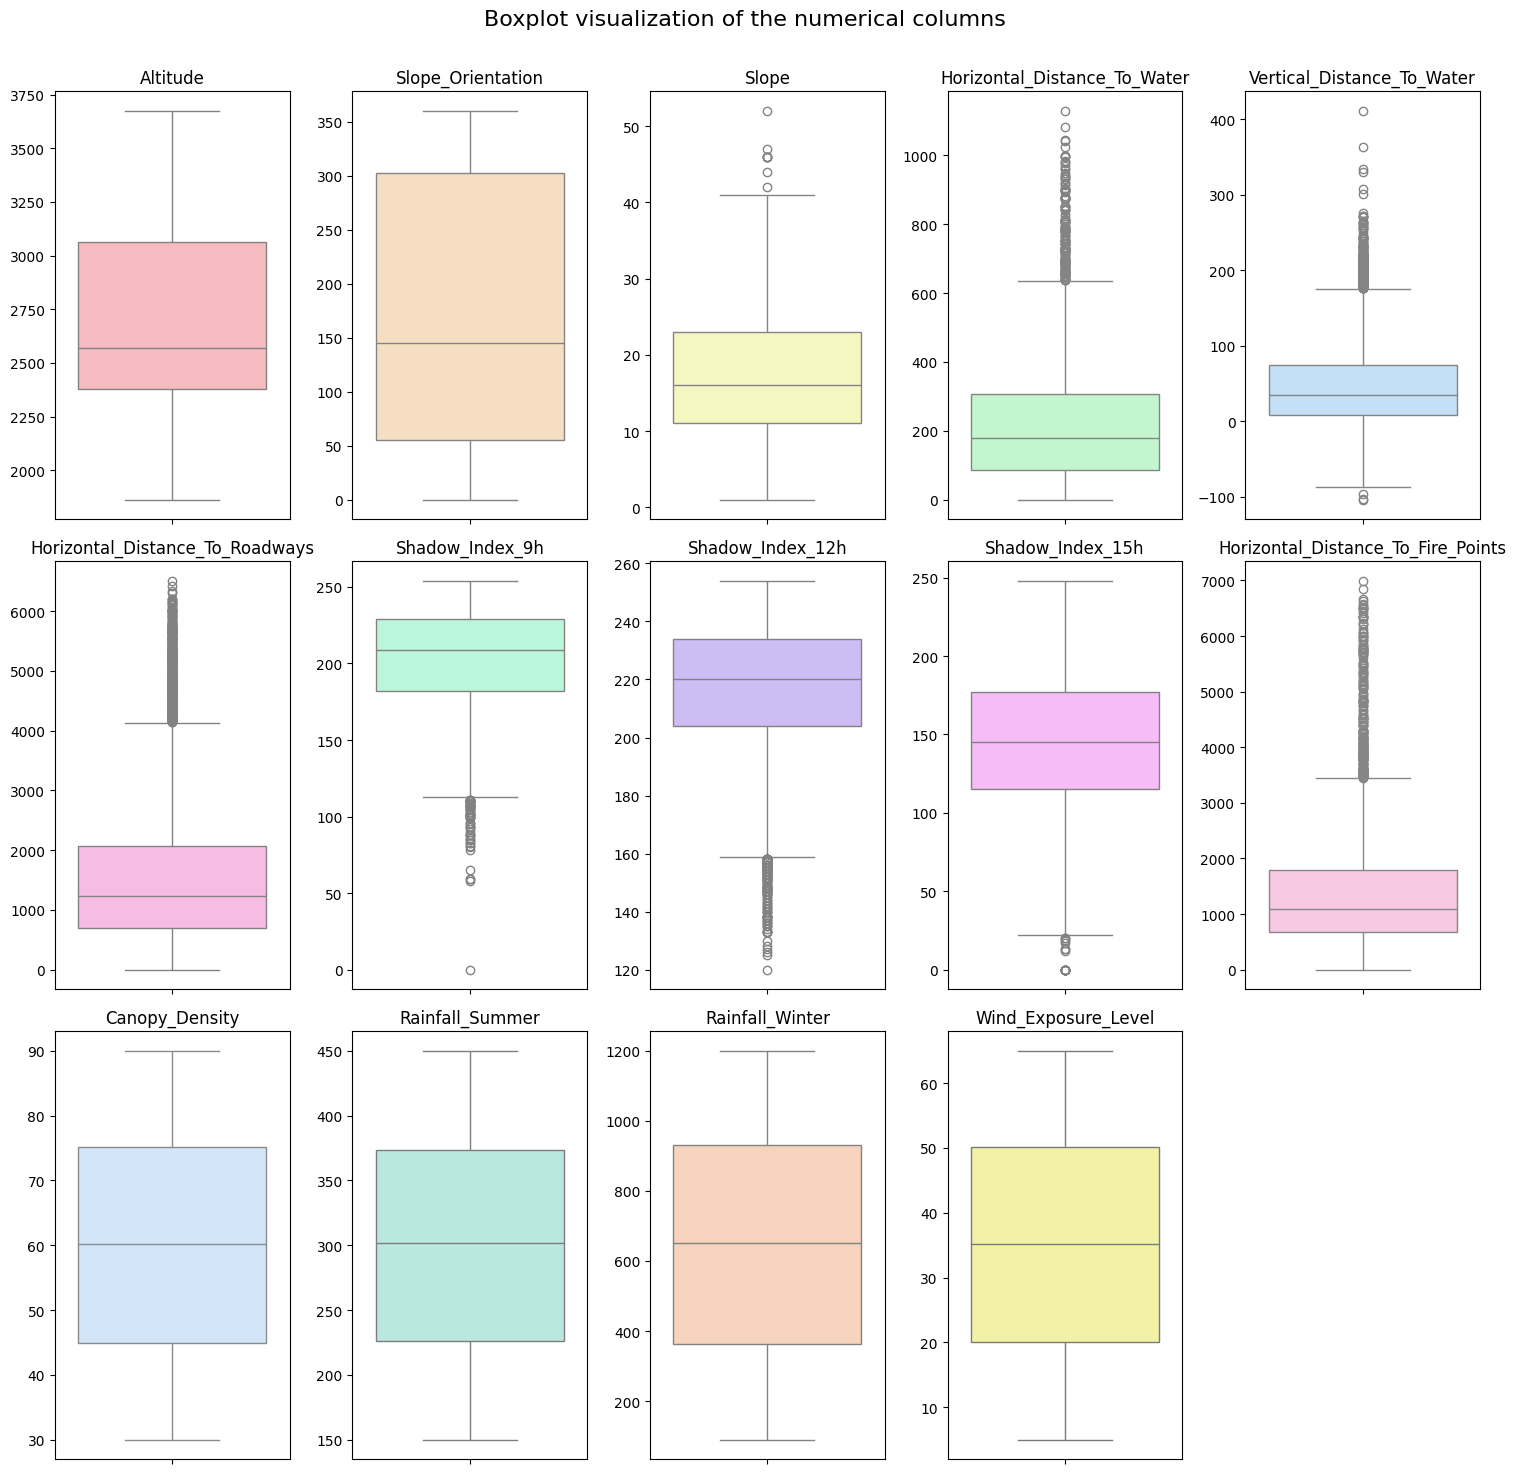

In [8]:
# Draw the boxplot visualizations of the numerical columns

boxplot_visualization(data, numerical_columns, 'Boxplot visualization of the numerical columns')

- Several columns such as the Horizontal_Distance_To_Water, Horizontal_Distance_To_Roadways, and Horizontal_Distance_To_Fire_Points have a significant number of outliers. 
These outliers may appear since different types of vegetation may have very distinct characteristics and values linked to them. If further investigation reveals that it is not the case, they may affect the performance of the models and it might be important to consider removing them.
- Given the length of the boxes, the majority of the data contains less variability since have narrow boxes. The Slope_Orientation column has a wide box, so we can identify that the values have more variability.

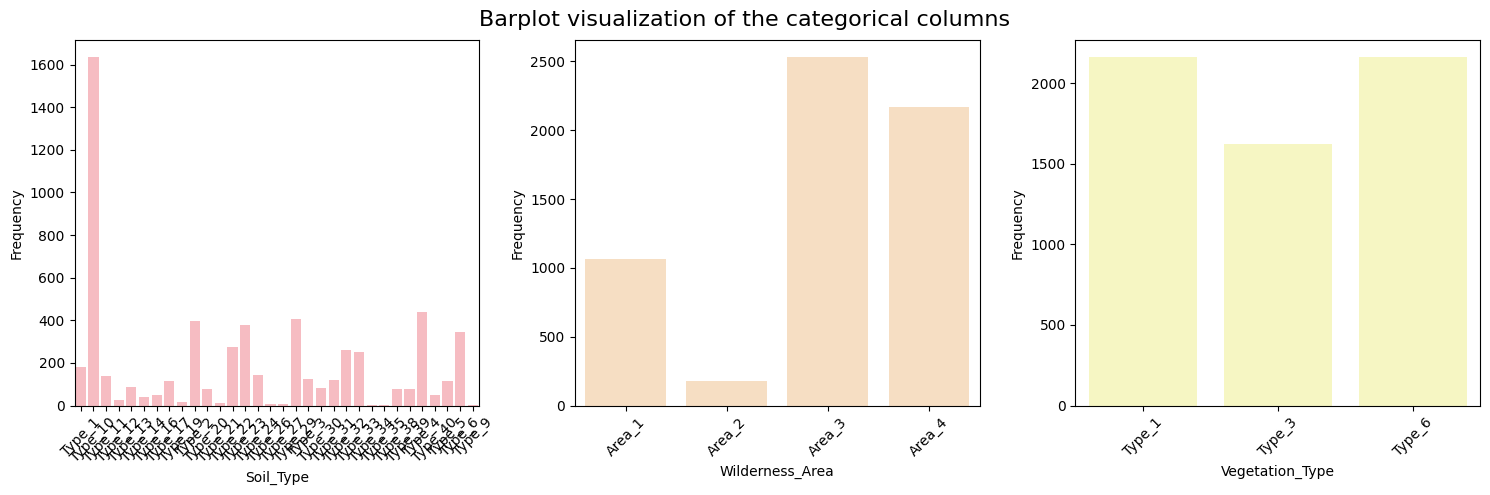

In [9]:
# Draw the barplot visualizations of the categorical columns

barplot_visualization(data, categorical_columns, 'Barplot visualization of the categorical columns')

- Given the distribution of the categorical columns there are clear outliers in the Soil_Type and Wilderness_Area.
- Our classes appear in similar frequencies and it suggests that we will not encounter issues related to class imbalance, which is a crucial information to have in mind when evaluating the models.

## Bivariate Analysis

In [10]:
# Encode the categorical columns

encoded_data = data.copy()
encoded_data['Soil_Type_Enc'] = pd.factorize(data['Soil_Type'])[0]
encoded_data['Wilderness_Area_Enc'] = pd.factorize(data['Wilderness_Area'])[0]
encoded_data['Vegetation_Type_Enc'] = pd.factorize(data['Vegetation_Type'])[0]

In [11]:
# Generate descriptive statistics of data after encoding

encoded_data.describe()

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level,Soil_Type_Enc,Wilderness_Area_Enc,Vegetation_Type_Enc
count,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000
mean,8038.627946,2672.851684,171.001347,17.276263,214.397475,48.701347,1588.265488,202.461448,216.604882,144.623232,1360.505387,60.077453,300.091620,647.547544,35.107199,15.752862,1.581650,1.000000
std,4201.653201,387.964294,121.193059,8.397512,176.610733,54.068275,1265.901292,33.925223,23.720654,44.343675,998.115844,17.404128,86.575054,323.281830,17.442532,8.008764,1.153733,0.852875
min,41.000000,1863.000000,0.000000,1.000000,0.000000,-104.000000,0.000000,0.000000,120.000000,0.000000,0.000000,30.000000,150.030000,90.070000,5.000000,0.000000,0.000000,0.000000
25%,4926.250000,2378.000000,55.000000,11.000000,85.000000,8.000000,695.250000,182.000000,204.000000,115.000000,674.000000,44.910000,225.855000,363.685000,20.010000,10.000000,1.000000,0.000000
50%,8070.000000,2572.000000,145.000000,16.000000,180.000000,34.000000,1230.000000,209.000000,220.000000,145.000000,1095.000000,60.190000,301.910000,650.650000,35.215000,18.000000,1.000000,1.000000
75%,11311.250000,3062.000000,302.000000,23.000000,306.000000,75.000000,2072.000000,229.000000,234.000000,177.250000,1785.000000,75.147500,373.827500,930.800000,50.205000,18.000000,3.000000,2.000000
max,15118.000000,3675.000000,360.000000,52.000000,1129.000000,411.000000,6508.000000,254.000000,254.000000,248.000000,6993.000000,89.990000,449.970000,1199.880000,64.990000,31.000000,3.000000,2.000000


The encoded data has the following characteristics:
- The columns have different ranges of values, since the encoding was done based on the number of unique values in each column
- The mean and median values are close to each other, indicating that the data is not skewed
- The column with the highest standard deviation is the Soil_Type_Enc column, indicating that the data is spread out from the mean


In [12]:
# Remove Id for correlation matrix

encoded_data_without_id = encoded_data.drop('Id', axis=1)

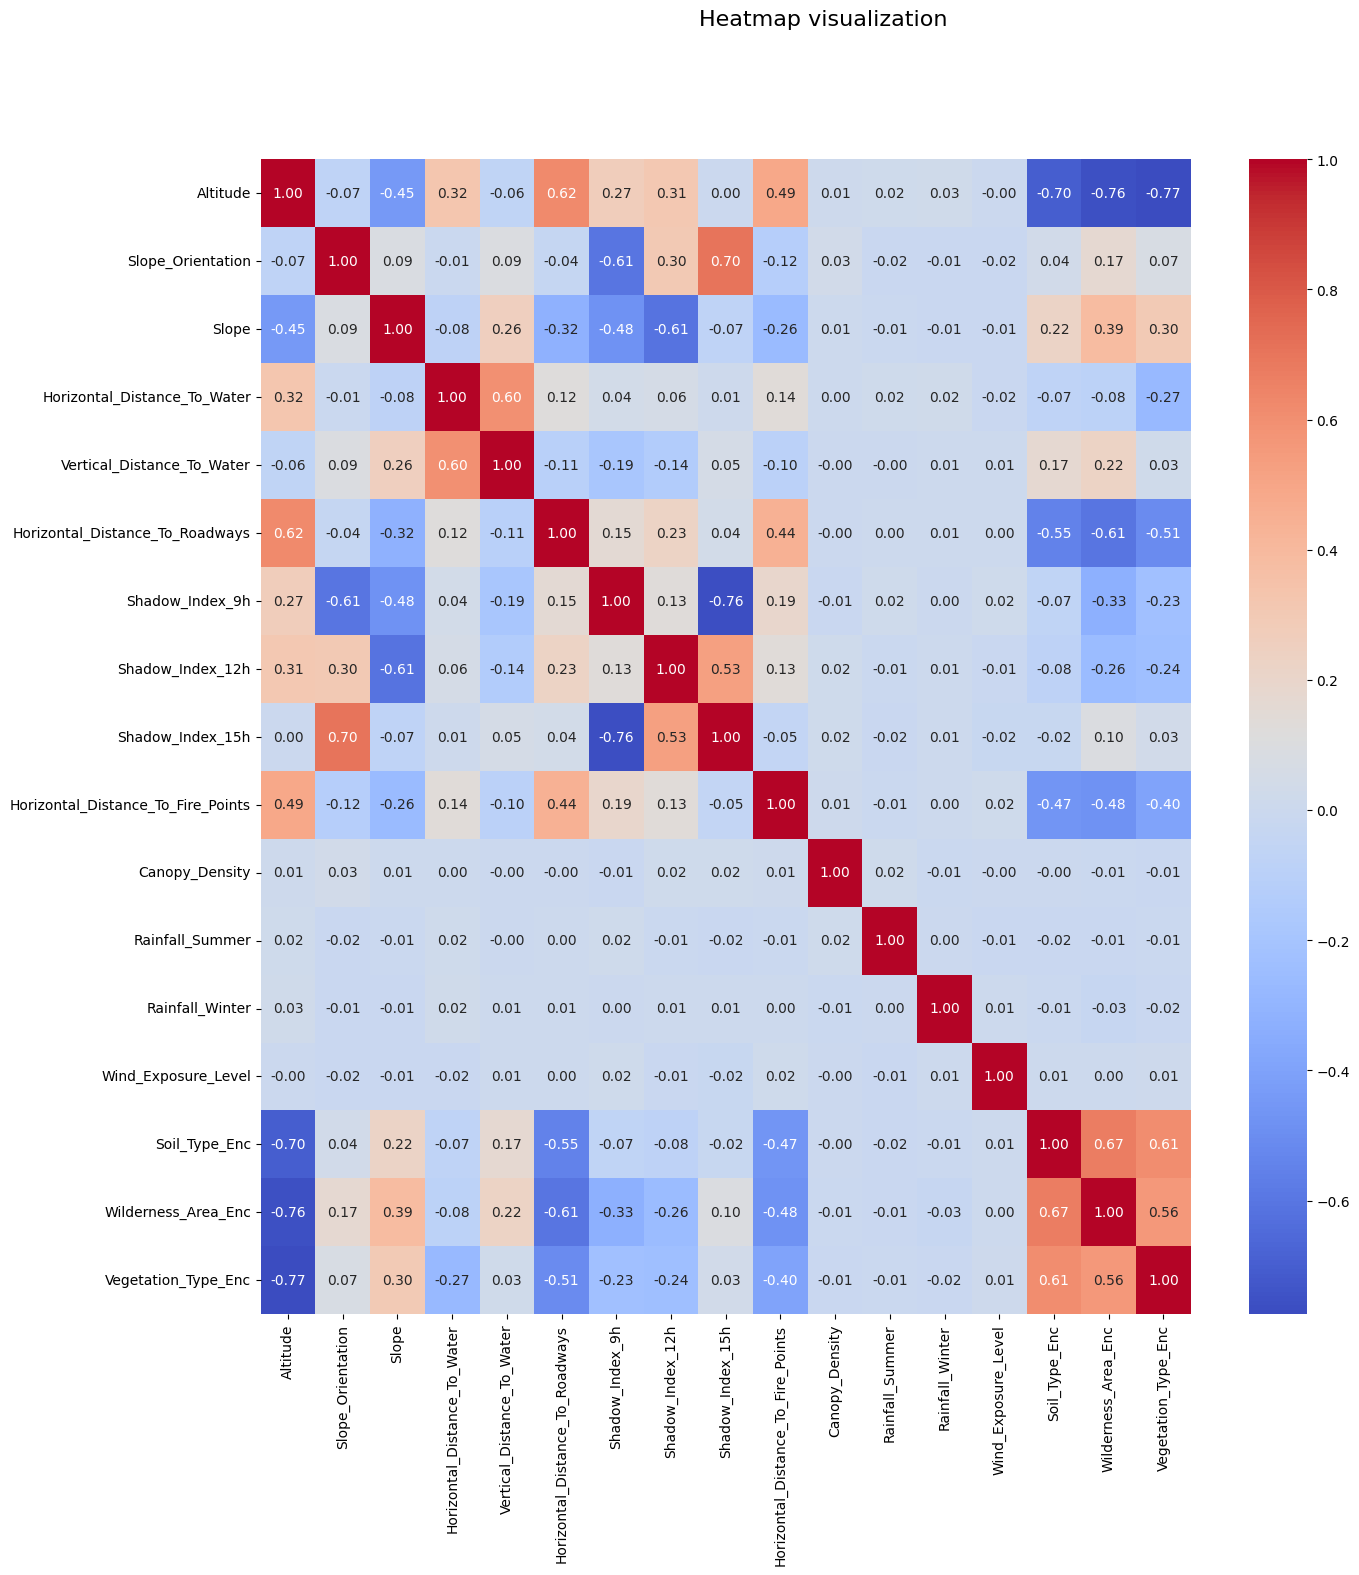

In [13]:
# Generate heatmap of the data

heatmap_visualization(encoded_data_without_id, 'Heatmap visualization')

The correlation of the features with the target column varies a lot and we can see that we have both highly correlated and uncorrelated features. The first ones may be the most important for our analysis, while the second ones may not provide any benefit.
In the next step, the columns with close to 0 correlation with the target column will be deleted, seeing as these do not provide any benefit to our analysis.

This applies to the following columns:
- Canopy_Density
- Rainfall_Summer
- Rainfall_Winter
- Wind_Exposure_Level

In [14]:
# Removing the columns without any correlation

encoded_data_without_id = encoded_data_without_id.drop(['Canopy_Density', 'Rainfall_Summer', 'Rainfall_Winter', 'Wind_Exposure_Level'], axis=1)

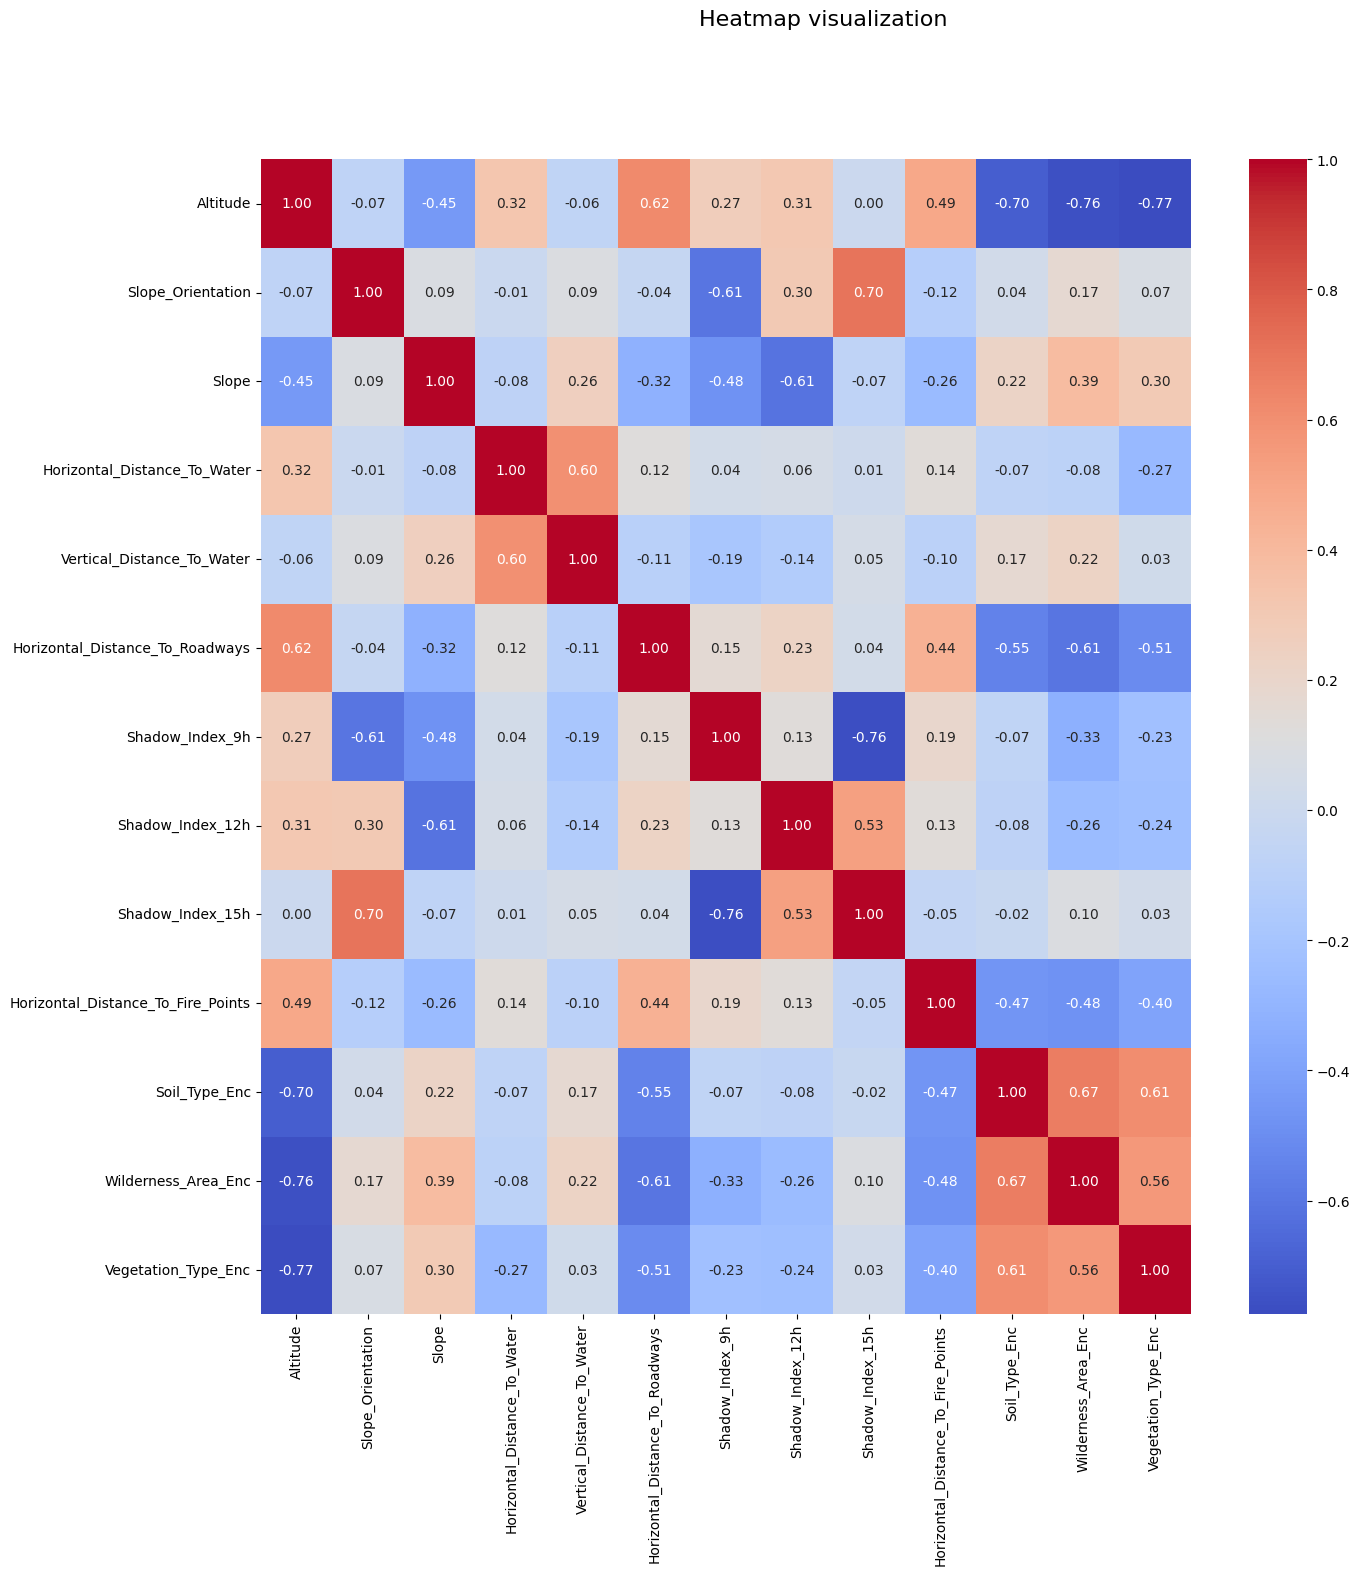

In [15]:
# Generate the heatmap of the data after removing the columns

heatmap_visualization(encoded_data_without_id, 'Heatmap visualization')

- Without the columns that do not correlate with the target column, we can see that the correlation between the features and the target column is more evident. All these columns may help, to some extent, to predict the target column.

In [16]:
# Display the correlation matrix

corr_matrix = encoded_data_without_id.corr(numeric_only=True)
corr_matrix['Vegetation_Type_Enc'].sort_values()

Altitude                             -0.774637
Horizontal_Distance_To_Roadways      -0.510261
Horizontal_Distance_To_Fire_Points   -0.400223
Horizontal_Distance_To_Water         -0.269011
Shadow_Index_12h                     -0.238884
Shadow_Index_9h                      -0.227859
Vertical_Distance_To_Water            0.028331
Shadow_Index_15h                      0.034780
Slope_Orientation                     0.074433
Slope                                 0.298247
Wilderness_Area_Enc                   0.560754
Soil_Type_Enc                         0.608980
Vegetation_Type_Enc                   1.000000
Name: Vegetation_Type_Enc, dtype: float64

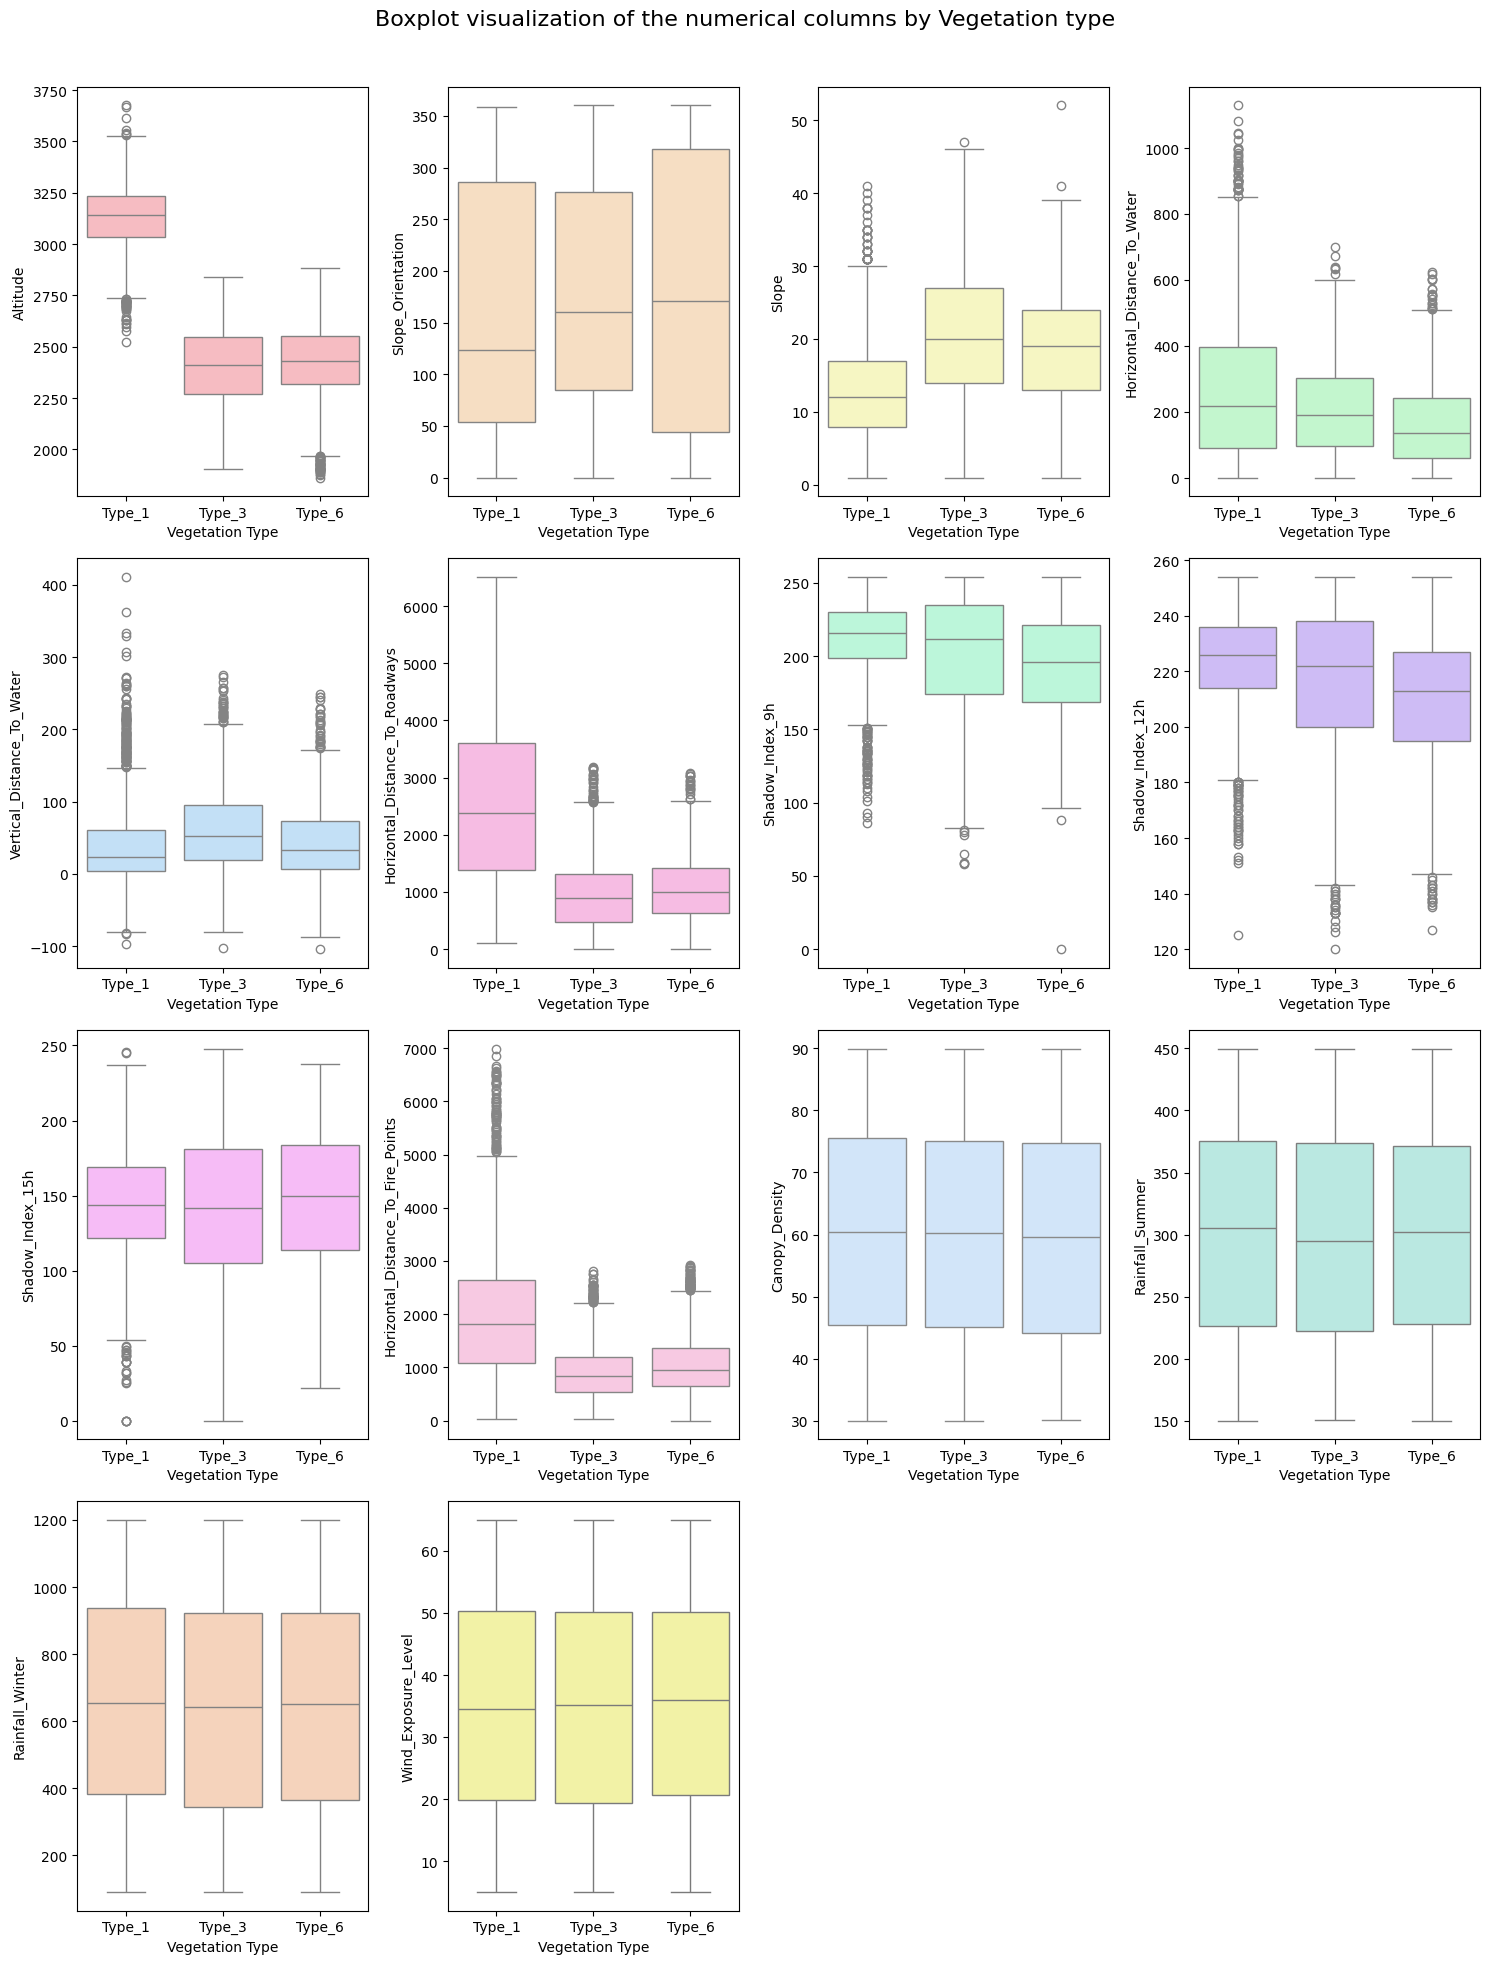

In [17]:
# Draw the boxplot visualizations of the numerical columns by Vegetation type (Target variable)

boxplot_by_type_visualization(data, numerical_columns, 'Boxplot visualization of the numerical columns by Vegetation type')

- In the boxplots there are some columns that have outliers for each different Vegetation_Type.
- Some features like the Altitude, Horizontal_Distance_To_Roadways, slope and Horizontal_Distance_To_Fire_Points have very distinct boxes for the Type_1 of the target variable. This indicates that these columns might be very good predictors of the label.

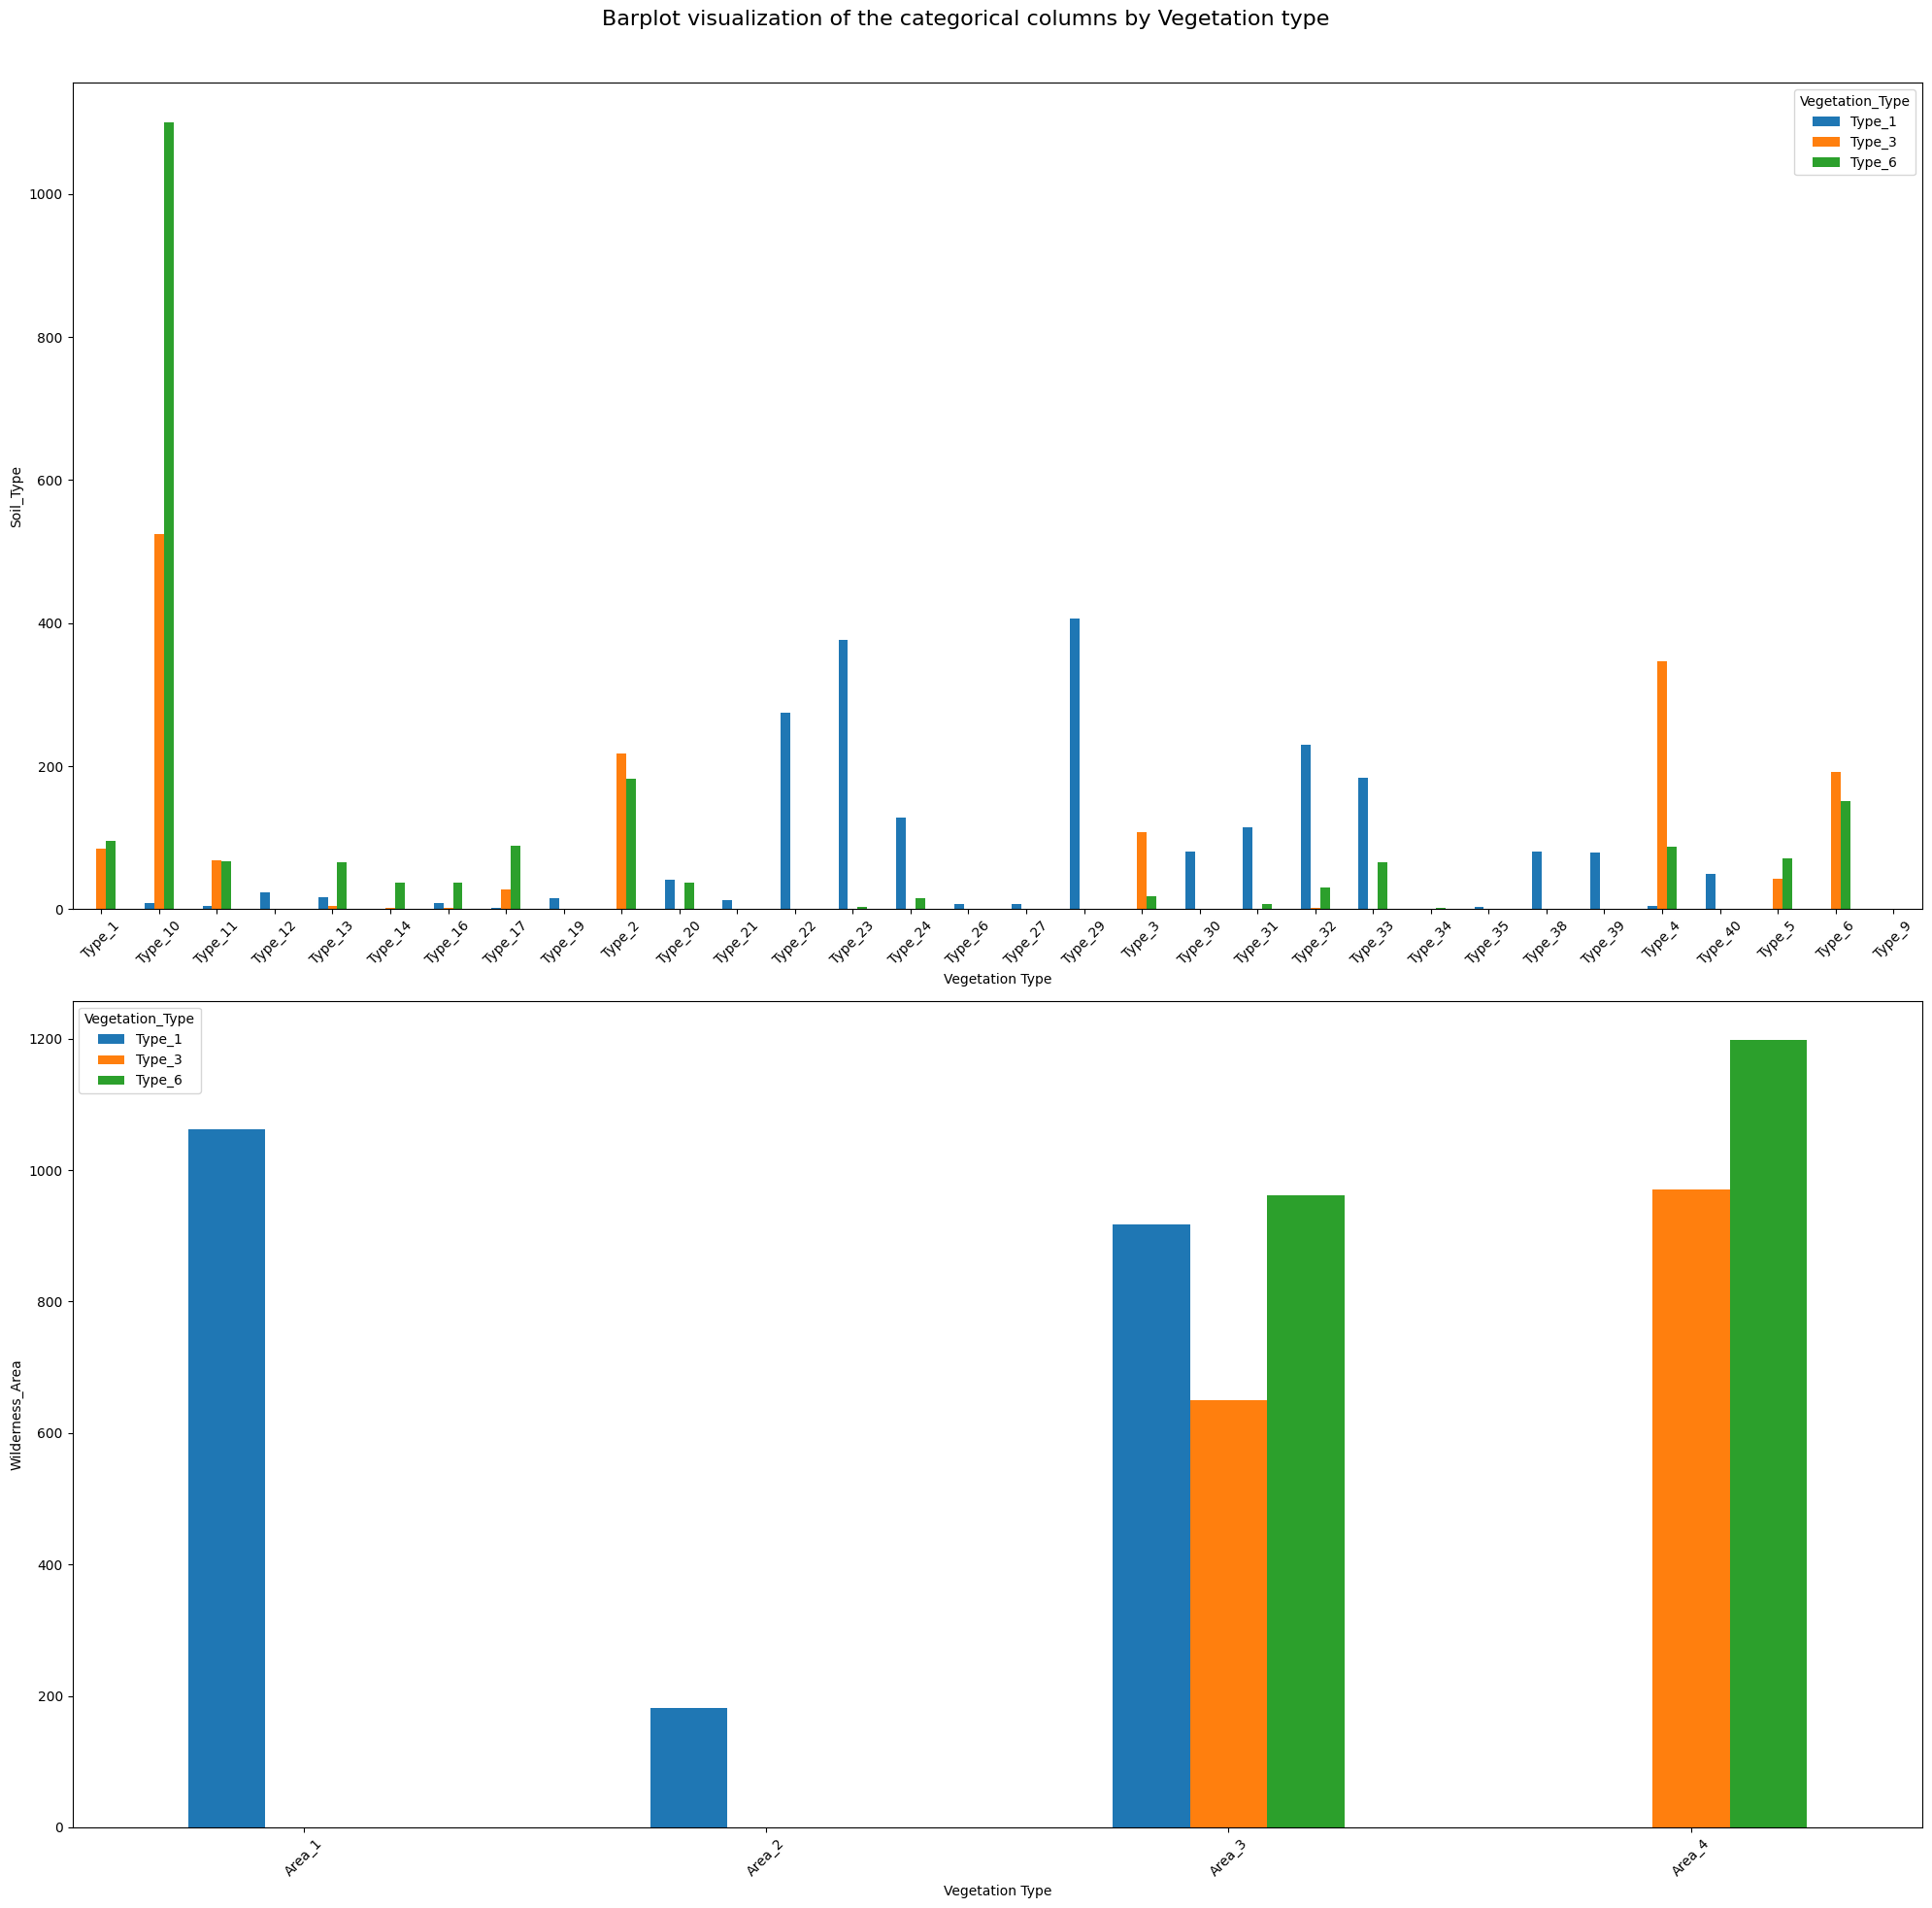

In [18]:
# Draw the crosstable visualizations of the numerical columns by Vegetation type (Target variable)

crosstab_by_type_visualization(data, categorical_columns, 'Barplot visualization of the categorical columns by Vegetation type')

- The crosstables show that some values of the categorical features are more frequent or even exclusive in some classes than in others. This indicates that these columns may be good predictors of the target variable.

## Methods Application

In [19]:
# Load the models to be evaluated

models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}

### Data Preparation

In [20]:
# Divide the data into features and target variable and separate the training and test data

X = encoded_data.drop(columns=['Vegetation_Type', 'Soil_Type', 'Wilderness_Area','Vegetation_Type_Enc', 'Id'])
y = encoded_data['Vegetation_Type_Enc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Rescales each feature to have a mean of 0 and a standard deviation of 1

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# Dataframe to store the metrics for each model and method

data_results = pd.DataFrame(columns=['Model', 'Method', 'Accuracy', 'Precision', 'Recall', 'F1', 'Std Dev', 'Confusion Matrix'])

- Since our dataset is balanced, we can use the accuracy metric to evaluate the models since it gives us a good overview of the model's performance.
- It is also useful to use the precision, recall to ensure that the model is not biased towards a specific class. Given the fact that we want to balance the precision and recall, the F1 score is a good metric to use.
- The confusion matrix will help identify misclassifications since it shows the number of correct and incorrect predictions for each class.

### Holdout Method

In [23]:
holdout_evaluation(data_results,models, X, y)

### Cross Validation (K=5)

In [24]:
cross_validation_evaluation(data_results,models, X, y, 5)

### Cross Validation (K=10)

In [25]:
cross_validation_evaluation(data_results,models, X, y, 10)

### Leave One Out Cross Validation (LOOCV)

In [26]:
loocv_evaluation(data_results, models, X, y)

### Bootstrap

In [27]:
bootstrap_evaluation(data_results, models,X, y, 100)

### Results 

In [28]:
# Display the dataframe with the metrics for each model and method

data_results

,Model,Method,Accuracy,Precision,Recall,F1,Std Dev,Confusion Matrix
0,Logistic Regression,Houldout,0.802694,0.803416,0.802694,0.799051,0.006209,"[[6391, 11, 90], [5, 2673, 2191], [59, 1160, 5..."
1,LDA,Houldout,0.799270,0.800241,0.799270,0.794730,0.005353,"[[6388, 12, 92], [1, 2596, 2272], [97, 1103, 5..."
2,QDA,Houldout,0.809484,0.811471,0.809484,0.807627,0.011984,"[[6320, 50, 122], [0, 2840, 2029], [25, 1169, ..."
3,Logistic Regression,Cross-Validation with 5,0.798822,0.799251,0.798822,0.794894,0.005952,"[[2130, 3, 27], [2, 870, 748], [15, 400, 1745]]"
4,LDA,Cross-Validation with 5,0.794444,0.794859,0.794444,0.789895,0.006700,"[[2126, 3, 31], [0, 851, 769], [31, 387, 1742]]"
5,QDA,Cross-Validation with 5,0.805724,0.807798,0.805724,0.803017,0.005172,"[[2107, 14, 39], [0, 908, 712], [7, 382, 1771]]"
6,Logistic Regression,Cross-Validation with 10,0.799663,0.800198,0.799663,0.795706,0.020797,"[[2129, 3, 28], [1, 874, 745], [17, 396, 1747]]"
7,LDA,Cross-Validation with 10,0.795118,0.796028,0.795118,0.790459,0.018763,"[[2125, 4, 31], [0, 849, 771], [30, 381, 1749]]"
8,QDA,Cross-Validation with 10,0.808923,0.811558,0.808923,0.806046,0.014526,"[[2106, 14, 40], [0, 912, 708], [8, 365, 1787]]"
9,Logistic Regression,LeaveOneOut,0.799158,0.799158,0.799158,0.799158,0.400630,"[[2130, 3, 27], [2, 875, 743], [19, 399, 1742]]"


- As we can see above, the models have similar results since the accuracy, precision, recall and F1 scores are in the range of 0.78 to 0.80. This can indicate that the performance of the models is consistent.
- As the variance equals to the square of the standard deviation, we can conclude that the resampling method have an impact on the results. The methods with the lowest variance are the Cross Validation with K=5 and the Bootstrap. Cross Validation with K=10 has the highest variance and Holdout method does not have a variance since it is a single split. 

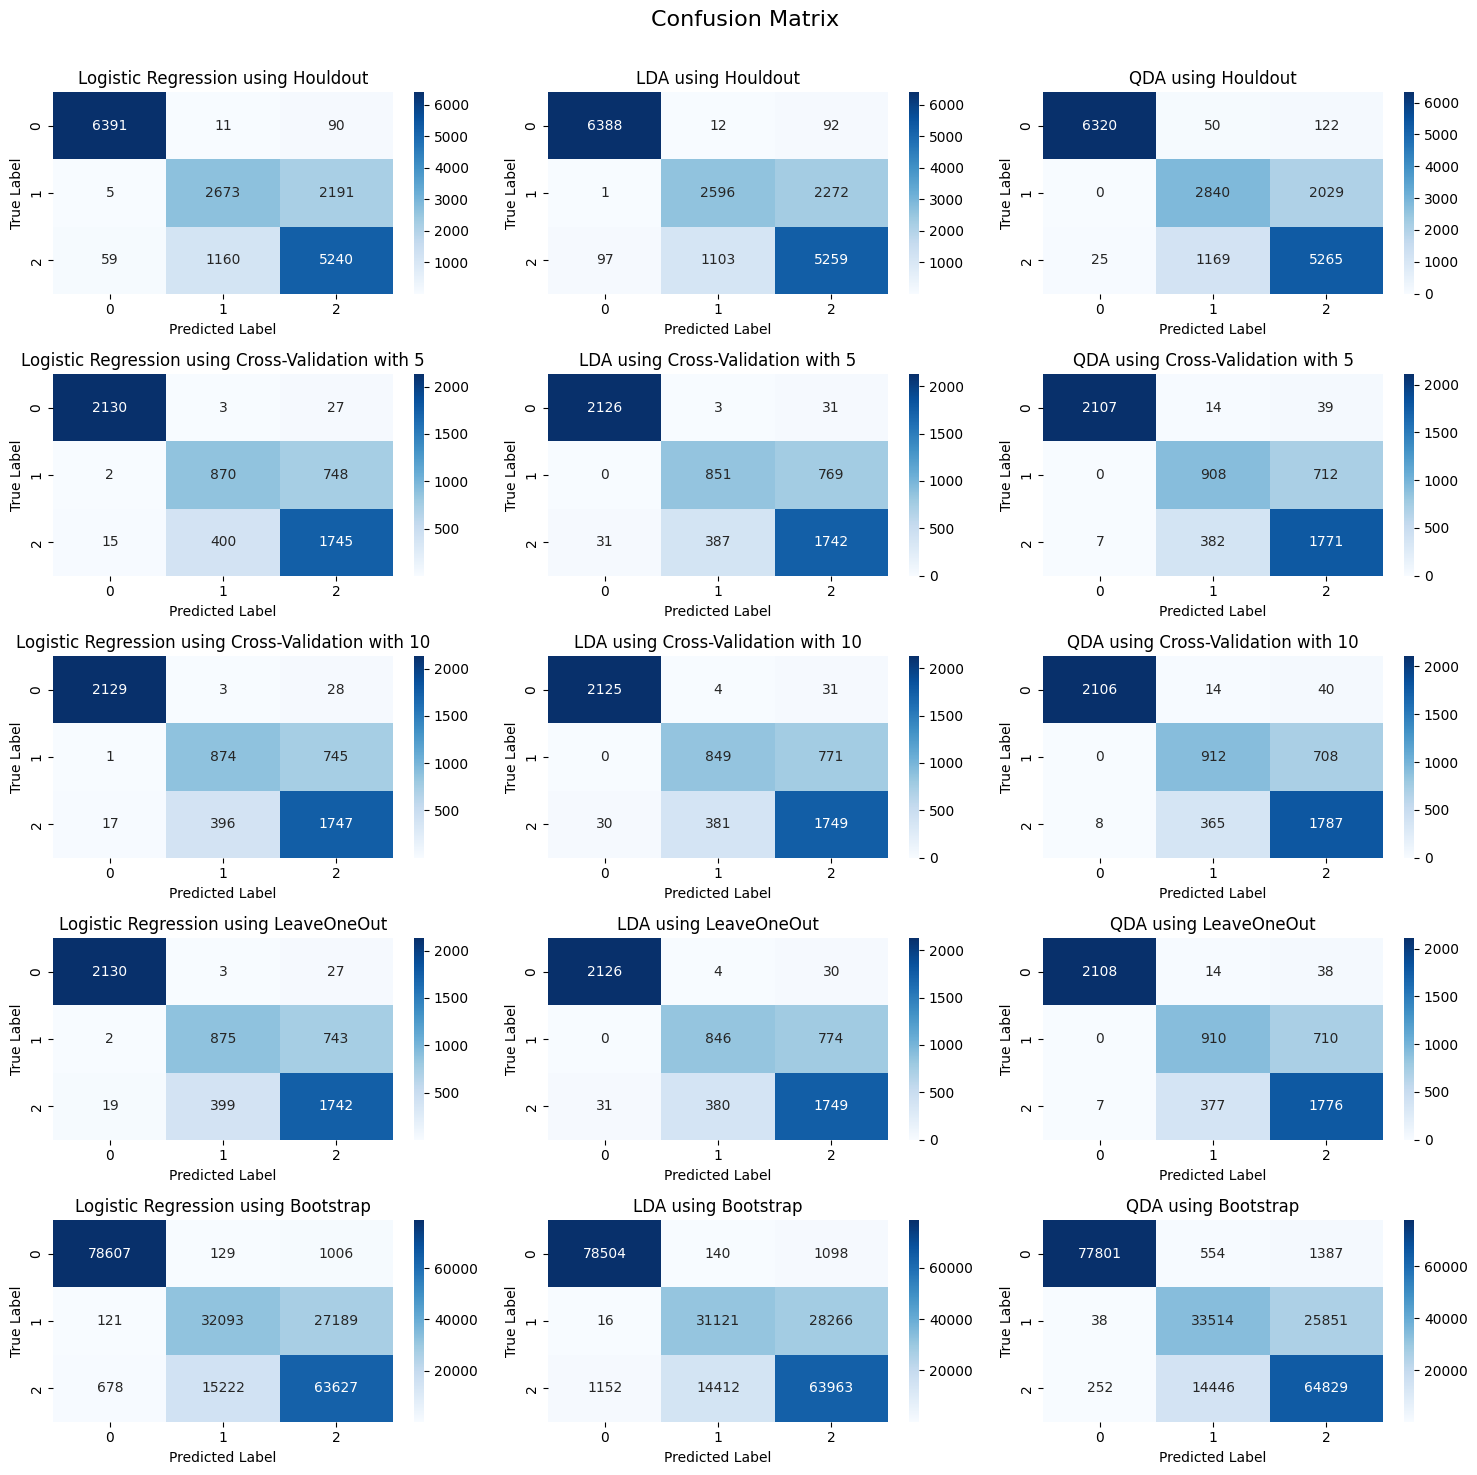

In [29]:
confusion_matrix_visualization(data_results, 'Confusion Matrix')

With theses confusion matrices, we can see that the all the models can easily identify the first Vegetation Type, while for the other two, it has more difficulty in distinguising between them, resulting in a lot of wrong predictions. This is expected considering that, as we saw in our analysis before, there aren't many features which provide a distinction between the Vegetation Types 3 and 6.

In order to improve the results we need to optimize the parameters of the Logistic regression model using the regularization methods of Lasso, Ridge and Elastic Net

## Feature Selection

### Find the best range for C

In [30]:
# store the results of the best parameters and score for each method

columns_name = X.columns.tolist()
result_lasso = {'C':[], 'score': []}
result_ridge = {'C': [], 'score': []}
result_elasticnet = {'C': [], 'score': [], 'l1_ratio':[]}

In [31]:
# initialize the model we will use

model = LogisticRegression()

We will use search for the best value of the C parameter, which represents the inverse of regularization strength, utilizing different penalties that represent different regularization methods. We decided to use the solver "saga" since it is compatible with the three methods.

#### Lasso
##### 0 - 1

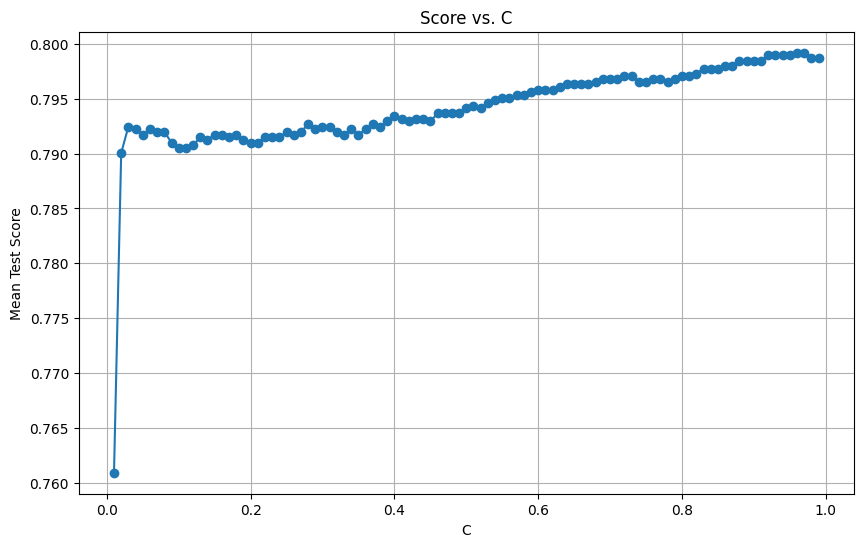

Best parameters: {'C': 0.96, 'penalty': 'l1', 'solver': 'saga'}
Best Score: 0.7991796260298065


In [32]:
# Define the parameters we will test, setting C values from 0 to 1 in increments of 0.01

parameters = {'C': np.arange(0, 1, 0.01), 
              'penalty': ['l1'], 
              'solver': ['saga']}

result_lasso = best_feature_grid_search_visualization(X_train, y_train, parameters, model, result_lasso)

#### 1 - 10

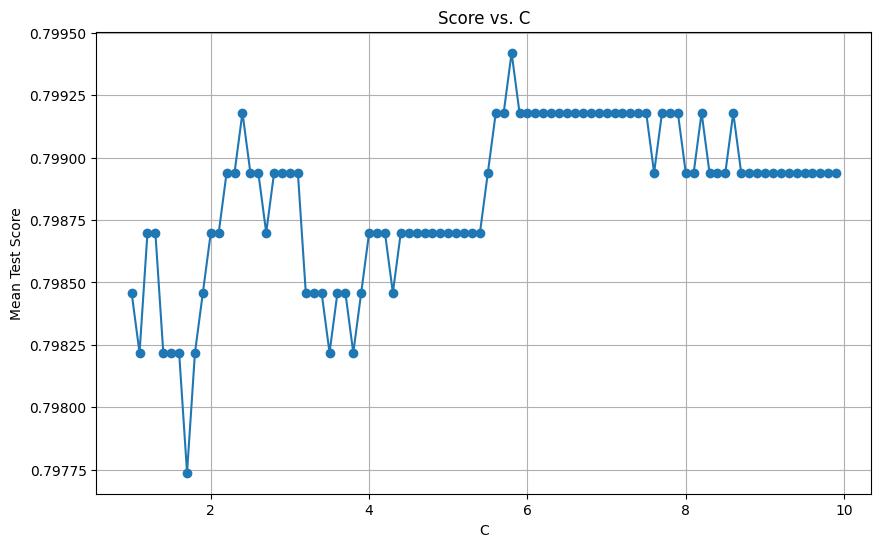

Best parameters: {'C': 5.800000000000004, 'penalty': 'l1', 'solver': 'saga'}
Best Score: 0.7994205891881885


In [33]:
# Define the parameters we will test, setting C values from 1 to 200 in increments of 1

parameters = {'C': np.arange(1,10, 0.1), 
              'penalty': ['l1'], 
              'solver': ['saga']}

result_lasso = best_feature_grid_search_visualization(X_train, y_train, parameters, model, result_lasso)

#### Rigde 
##### 0 - 1

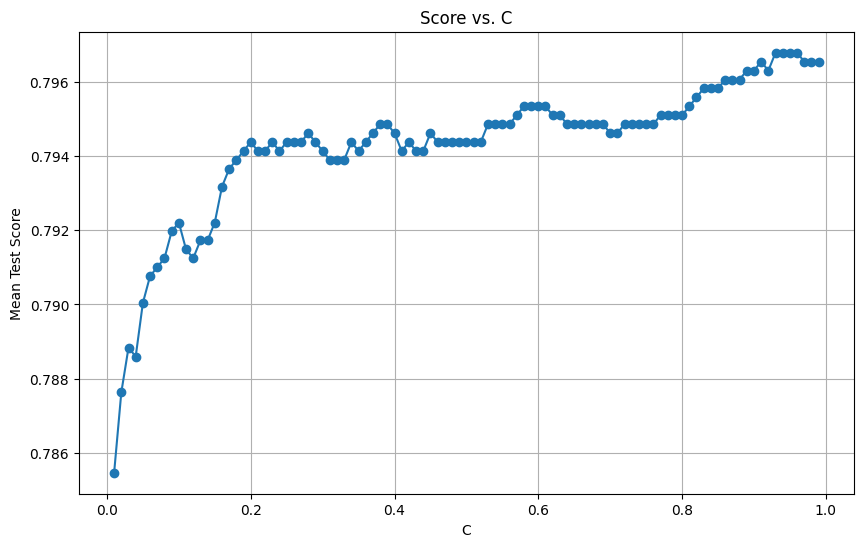

Best parameters: {'C': 0.93, 'penalty': 'l2', 'solver': 'saga'}
Best Score: 0.7967757798759604


In [34]:
# Define the parameters we will test, setting C values from 0 to 1 in increments of 0.01

parameters = {'C': np.arange(0, 1, 0.01), 
              'penalty': ['l2'], 
              'solver': ['saga']}
result_ridge = best_feature_grid_search_visualization(X_train, y_train, parameters, model, result_ridge)

##### 1 - 10

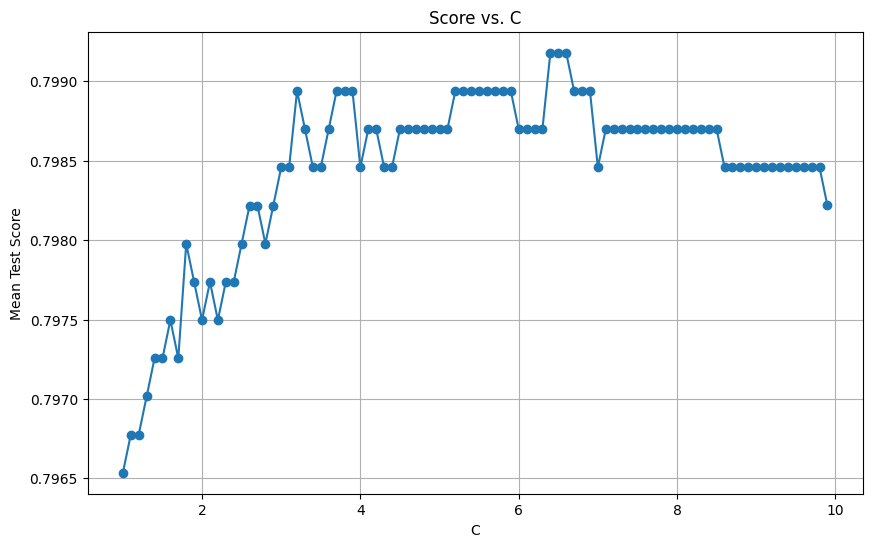

Best parameters: {'C': 6.400000000000005, 'penalty': 'l2', 'solver': 'saga'}
Best Score: 0.7991804938443025


In [35]:
# Define the parameters we will test, setting C values from 1 to 200 in increments of 1

parameters = {'C': np.arange(1,10, 0.1), 
              'penalty': ['l2'], 
              'solver': ['saga']}

result_ridge = best_feature_grid_search_visualization(X_train, y_train, parameters, model, result_ridge)

#### Elastic Net
##### 0 - 1

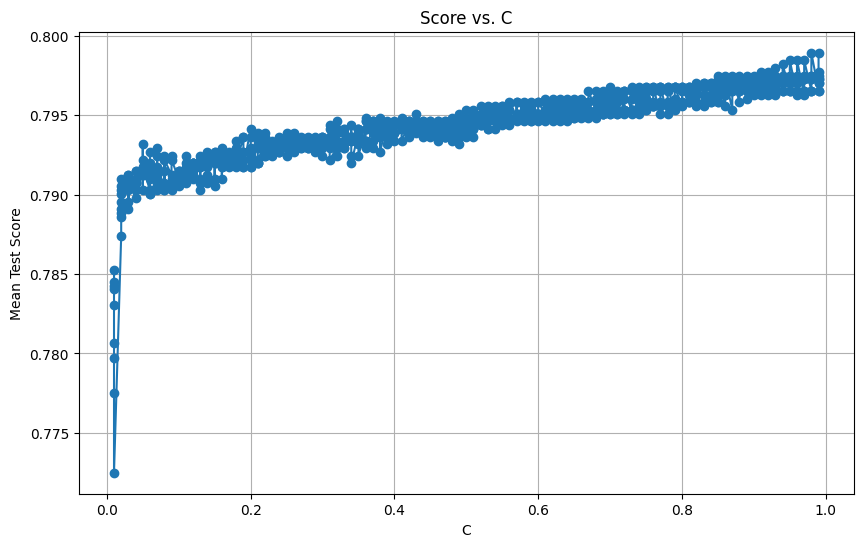

Best parameters: {'C': 0.98, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}
Best Score: 0.7989389521429233


In [36]:
# Define the parameters we will test, setting C values from 0 to 1 in increments of 0.01

parameters = {'C': np.arange(0,1, 0.01), 
              'penalty': ['elasticnet'], 
              'solver': ['saga'],
              'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

result_elasticnet = best_feature_grid_search_visualization(X_train, y_train, parameters, model, result_elasticnet)

##### 1 - 10

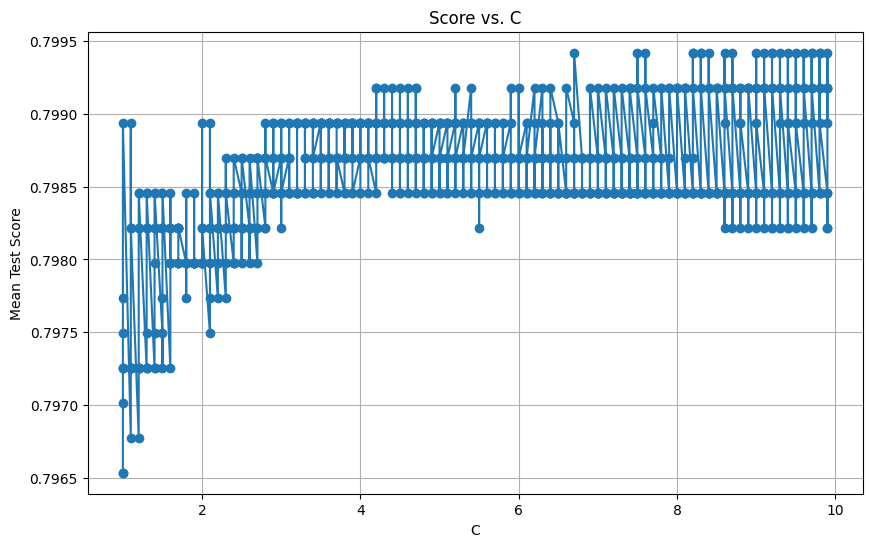

Best parameters: {'C': 6.700000000000005, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}
Best Score: 0.7994202999166897


In [37]:
# Define the parameters we will test, setting C values from 1 to 200 in increments of 1

parameters = {'C': np.arange(1,10, 0.1), 
              'penalty': ['elasticnet'], 
              'solver': ['saga'],
              'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

result_elasticnet = best_feature_grid_search_visualization(X_train, y_train, parameters, model, result_elasticnet)

Since the scores of the regularization models are all close to 80%, we will consider lasso as the best one since it also removes features, making the data and models simpler. 

##### Lasso

In [38]:
# Select the optimal regularization method between Lasso and Ridge, then perform a detailed search within a refined range around the previously identified best C value
c = np.arange(result_lasso['C'] - 0.5 ,result_lasso['C'] + 0.5 ,0.01)

parameters = {'C':c, 
              'penalty': ['l1'],  
              'solver': ['saga']}

best_feature_lasso = best_feature_grid_search(columns_name,X_train, y_train, parameters, model)

Best parameters: {'C': 5.809999999999993, 'penalty': 'l1', 'solver': 'saga'}
Feature Coefficients:
                               Feature  Coefficient
0                             Altitude     7.858858
1                    Slope_Orientation    -0.763519
2                                Slope     0.000000
3         Horizontal_Distance_To_Water     0.000000
4           Vertical_Distance_To_Water    -0.823335
5      Horizontal_Distance_To_Roadways     0.000000
6                      Shadow_Index_9h    -0.204420
7                     Shadow_Index_12h     0.442591
8                     Shadow_Index_15h     0.000000
9   Horizontal_Distance_To_Fire_Points     0.000000
10                      Canopy_Density     0.102580
11                     Rainfall_Summer    -0.043153
12                     Rainfall_Winter     0.102717
13                 Wind_Exposure_Level    -0.259885
14                       Soil_Type_Enc    -1.151491
15                 Wilderness_Area_Enc    -2.930942


We can observe that the best model gave more importance to the Altitude, Soil_Type_Enc and Wilderness_Area_Enc which is consistent with the analysis done earlier.

In [39]:
# Initialize the models with the best parameters

best_models_lr ={
    'Logistic Regression with Lasso': LogisticRegression(C=best_feature_lasso['C'], 
                                                         penalty=best_feature_lasso['penalty'], 
                                                         solver= 'saga')
}


### Holdout With Best Parameters

In [40]:
holdout_evaluation(data_results,best_models_lr, X, y)

### Cross Validation (K=5) With Best Parameters

In [41]:
cross_validation_evaluation(data_results, best_models_lr, X, y, 5)

### Cross Validation (K=10) With Best Parameters

In [42]:
cross_validation_evaluation(data_results,best_models_lr, X, y, 10)

### Leave One Out Cross Validation (LOOCV) With Best Parameters

In [43]:
loocv_evaluation(data_results, best_models_lr, X, y)

### Bootstrap With Best Parameters

In [44]:
bootstrap_evaluation(data_results, best_models_lr, X, y, 100)

### Results

In [45]:
data_results

,Model,Method,Accuracy,Precision,Recall,F1,Std Dev,Confusion Matrix
0,Logistic Regression,Houldout,0.802694,0.803416,0.802694,0.799051,0.006209,"[[6391, 11, 90], [5, 2673, 2191], [59, 1160, 5..."
1,LDA,Houldout,0.799270,0.800241,0.799270,0.794730,0.005353,"[[6388, 12, 92], [1, 2596, 2272], [97, 1103, 5..."
2,QDA,Houldout,0.809484,0.811471,0.809484,0.807627,0.011984,"[[6320, 50, 122], [0, 2840, 2029], [25, 1169, ..."
3,Logistic Regression,Cross-Validation with 5,0.798822,0.799251,0.798822,0.794894,0.005952,"[[2130, 3, 27], [2, 870, 748], [15, 400, 1745]]"
4,LDA,Cross-Validation with 5,0.794444,0.794859,0.794444,0.789895,0.006700,"[[2126, 3, 31], [0, 851, 769], [31, 387, 1742]]"
5,QDA,Cross-Validation with 5,0.805724,0.807798,0.805724,0.803017,0.005172,"[[2107, 14, 39], [0, 908, 712], [7, 382, 1771]]"
6,Logistic Regression,Cross-Validation with 10,0.799663,0.800198,0.799663,0.795706,0.020797,"[[2129, 3, 28], [1, 874, 745], [17, 396, 1747]]"
7,LDA,Cross-Validation with 10,0.795118,0.796028,0.795118,0.790459,0.018763,"[[2125, 4, 31], [0, 849, 771], [30, 381, 1749]]"
8,QDA,Cross-Validation with 10,0.808923,0.811558,0.808923,0.806046,0.014526,"[[2106, 14, 40], [0, 912, 708], [8, 365, 1787]]"
9,Logistic Regression,LeaveOneOut,0.799158,0.799158,0.799158,0.799158,0.400630,"[[2130, 3, 27], [2, 875, 743], [19, 399, 1742]]"


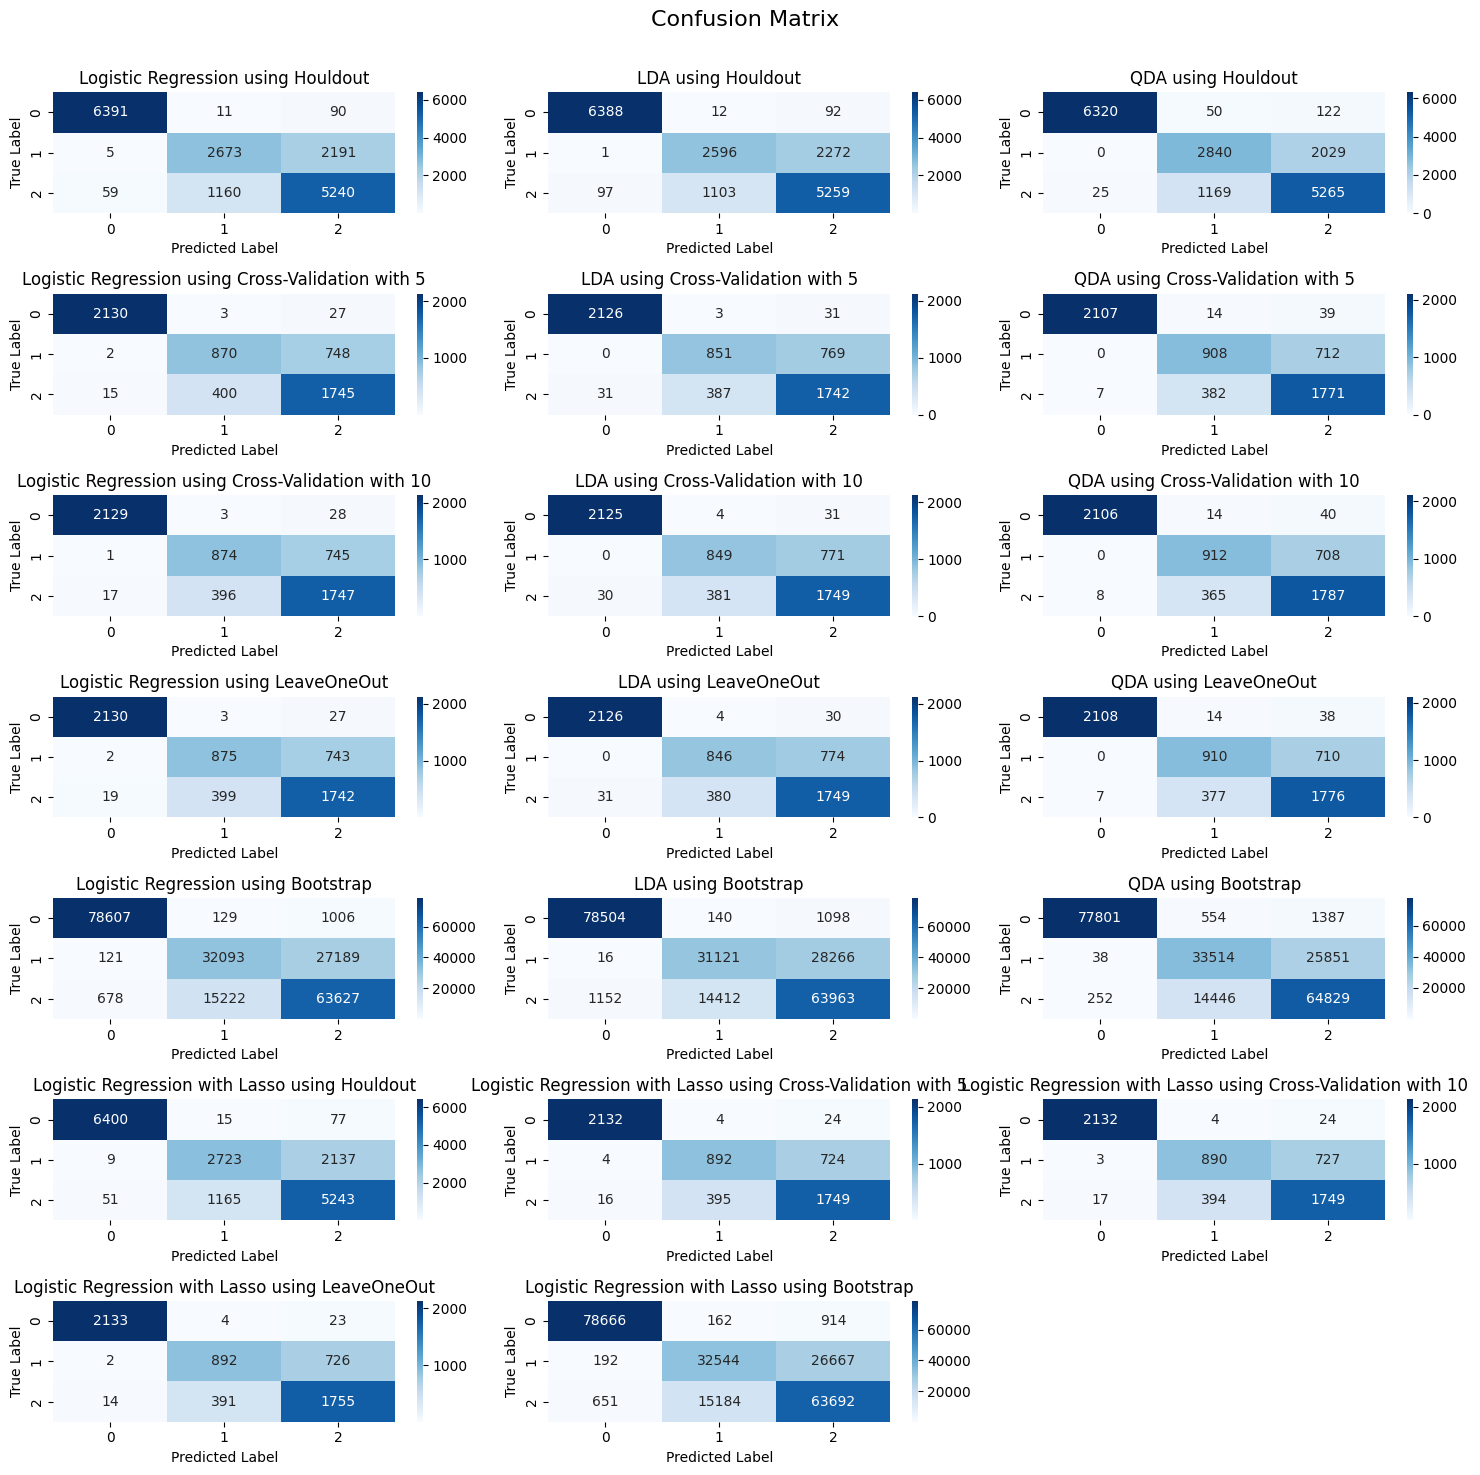

In [46]:
confusion_matrix_visualization(data_results, 'Confusion Matrix')

The results were not what we expected as there was only a small improvement, there still remains a big misclassification betweeen the label 1 often often classified as 2.

## Get data with Dummies

We tried getting the dummies of the categorical classes and only using the columns that had correlation above 0.3 with the objective since we considered that smaller values could indicate no correlation at all and few columns had values higher. Surprisingly the results did not improve and we opted to discard that approach.

Next we will apply the Ridge, Lasso and Elastic net methods regularization methods and test with the dummies data.

In [47]:
# Drop the encoded columns and get the dummies of the categorical columns

new_data =encoded_data_without_id.drop(
    columns=[
        'Vegetation_Type',
        'Soil_Type_Enc',
        'Wilderness_Area_Enc'
    ]
)
data_dummies = pd.get_dummies(new_data)

In [48]:
# Generate the correlation matrix

corr_matrix = data_dummies.corr()
sorted_corr = corr_matrix['Vegetation_Type_Enc'].sort_values()

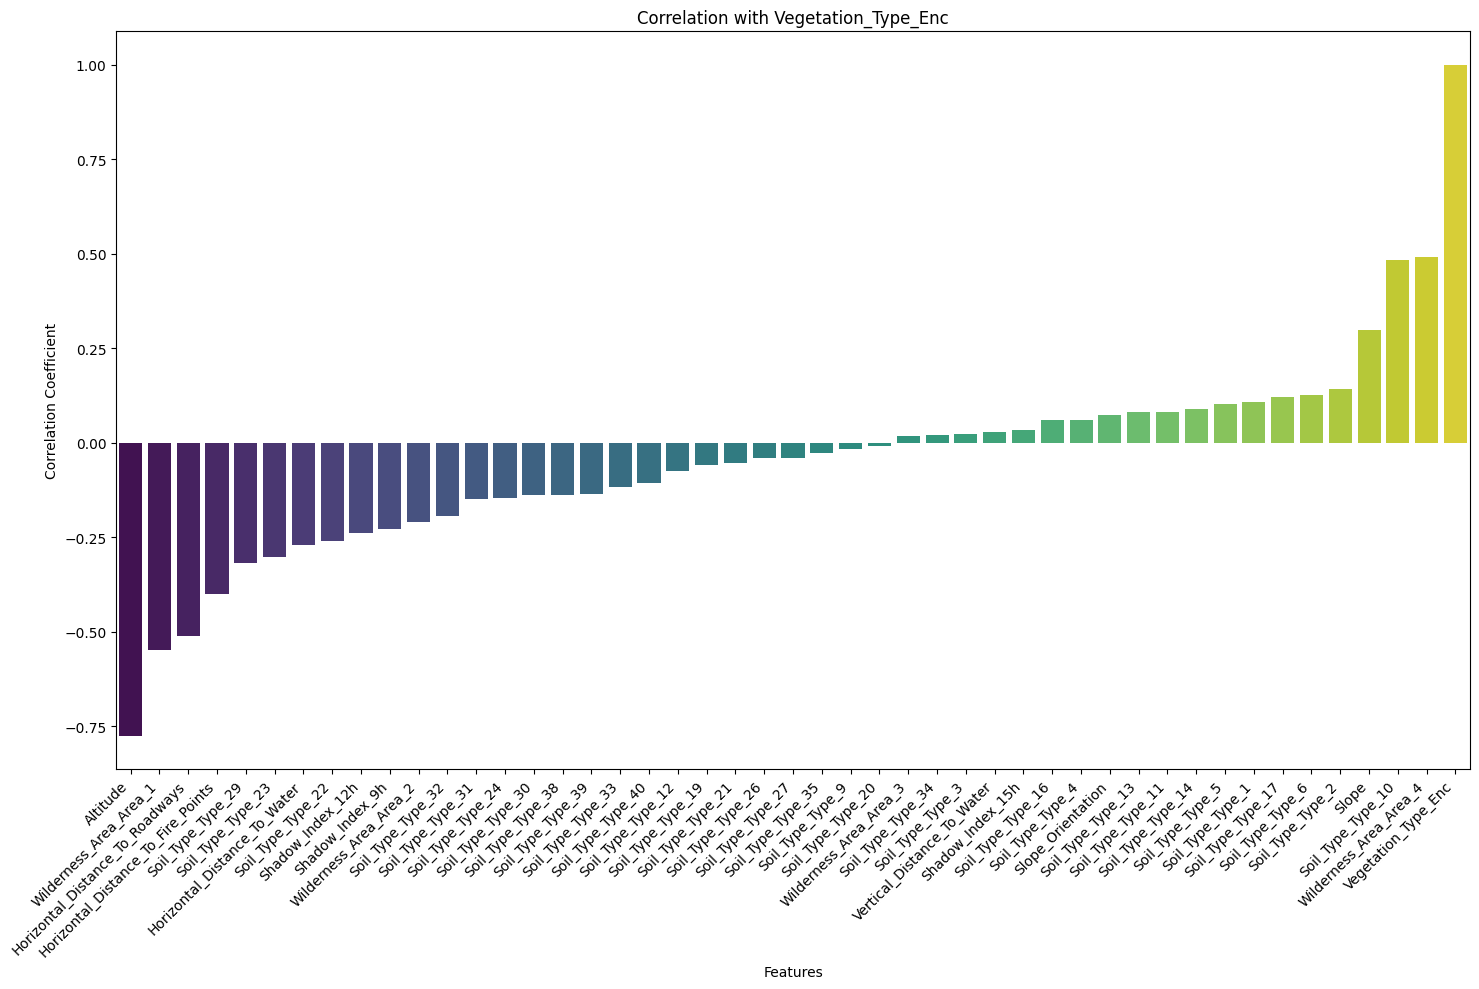

In [49]:
# Plotting the sorted correlations

barplot_correlation_visualization(sorted_corr, 'Correlation with Vegetation_Type_Enc')

The correlation of the features with the target column varies a lot and we can see that we have both highly correlated and uncorrelated features. We predict that the ones with higher correlation will have a bigger impact on the model predictions.

### Data Preparation with Dummies

In [50]:
# Preparing the data to use in the regularization methods

X_dummies = data_dummies.drop(columns=['Vegetation_Type_Enc'])
y_dummies = data_dummies['Vegetation_Type_Enc']
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y_dummies, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Data Preparation with Best Features and Dummies

We will now repeat the steps above to get the best parameters and test the models

#### Find the best range for C

In [51]:
columns_name = X_dummies.columns.tolist()
result_lasso = {'C': [], 'score': []}
result_ridge = {'C': [], 'score': []}
result_elasticnet = {'C': [], 'score': [], 'l1_ratio': []}

In [52]:
model = LogisticRegression()

##### Lasso
###### 0 - 1

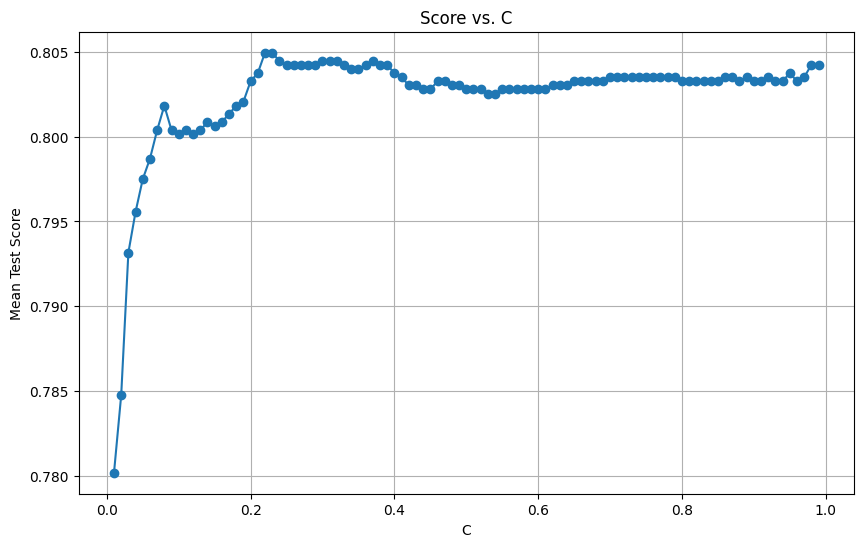

Best parameters: {'C': 0.22, 'penalty': 'l1', 'solver': 'saga'}
Best Score: 0.8049476997130427


In [53]:
parameters = {'C': np.arange(0, 1, 0.01), 
              'penalty': ['l1'], 
              'solver': ['saga']}

result_lasso = best_feature_grid_search_visualization(X_train, y_train, parameters, model, result_lasso)

###### 1 - 10

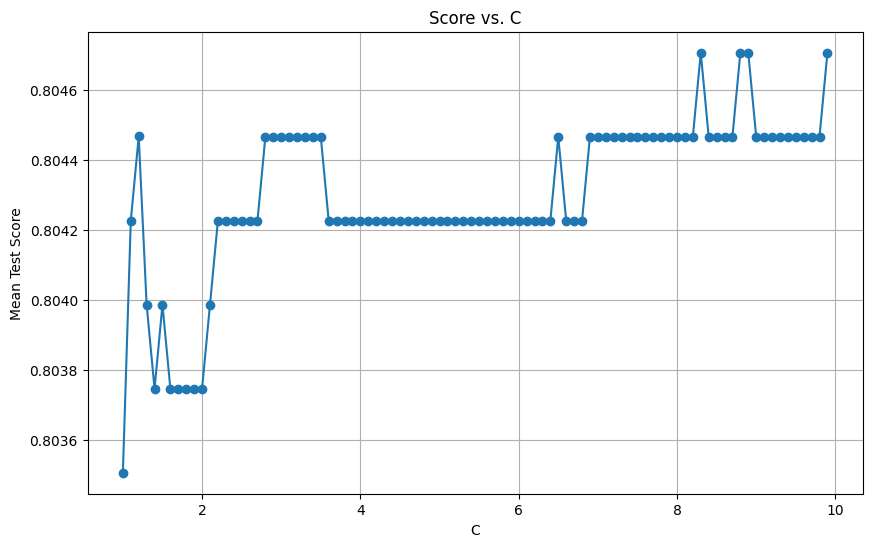

Best parameters: {'C': 8.300000000000006, 'penalty': 'l1', 'solver': 'saga'}
Best Score: 0.804707315097658


In [54]:
parameters = {'C': np.arange(1,10, 0.1), 
              'penalty': ['l1'], 
              'solver': ['saga']}

result_lasso = best_feature_grid_search_visualization(X_train, y_train, parameters, model, result_lasso)

##### Rigde 
###### 0 - 1

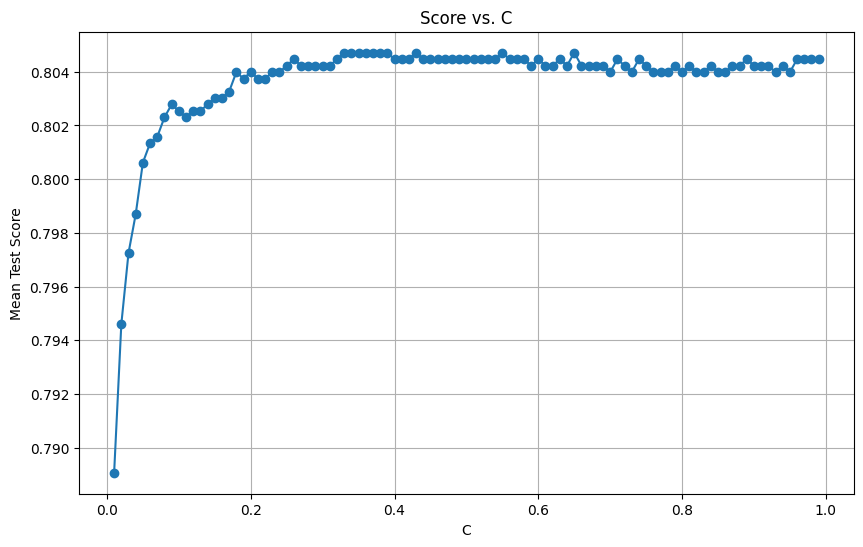

Best parameters: {'C': 0.43, 'penalty': 'l2', 'solver': 'saga'}
Best Score: 0.8047076043691568


In [55]:
parameters = {'C': np.arange(0, 1, 0.01), 
              'penalty': ['l2'], 
              'solver': ['saga']}

result_ridge = best_feature_grid_search_visualization(X_train, y_train, parameters, model, result_ridge)

###### 1 - 10

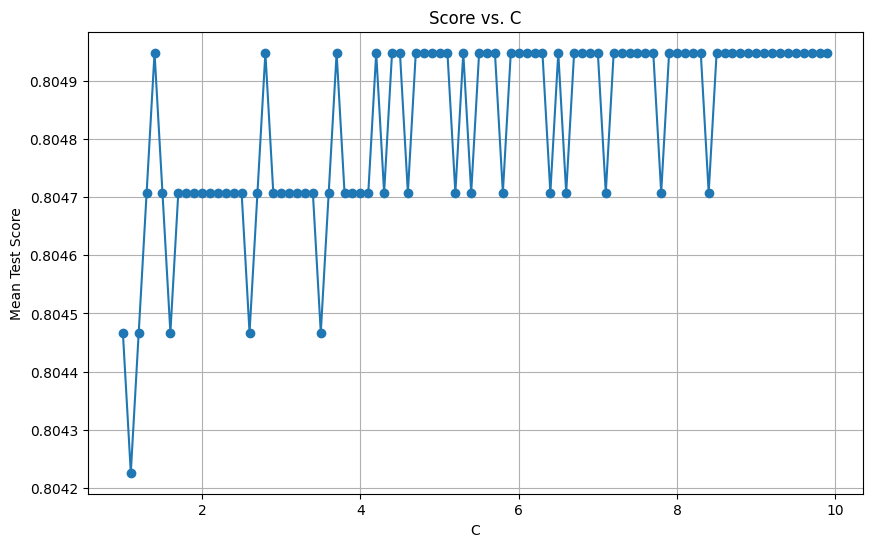

Best parameters: {'C': 1.4000000000000004, 'penalty': 'l2', 'solver': 'saga'}
Best Score: 0.8049479889845413


In [56]:
parameters = {'C': np.arange(1,10, 0.1), 
              'penalty': ['l2'], 
              'solver': ['saga']}

result_ridge = best_feature_grid_search_visualization(X_train, y_train, parameters, model, result_ridge)

##### Elastic Net
###### 0 - 1

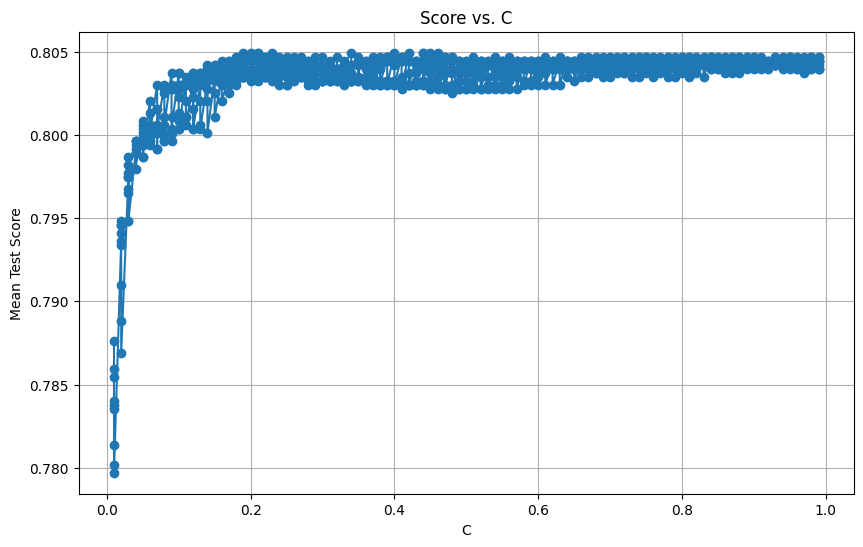

Best parameters: {'C': 0.34, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}
Best Score: 0.8049479889845413


In [57]:
parameters = {'C': np.arange(0, 1, 0.01), 
              'penalty': ['elasticnet'], 
              'solver': ['saga'],
              'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

result_elasticnet = best_feature_grid_search_visualization(X_train, y_train, parameters, model, result_elasticnet)

###### 1 - 10

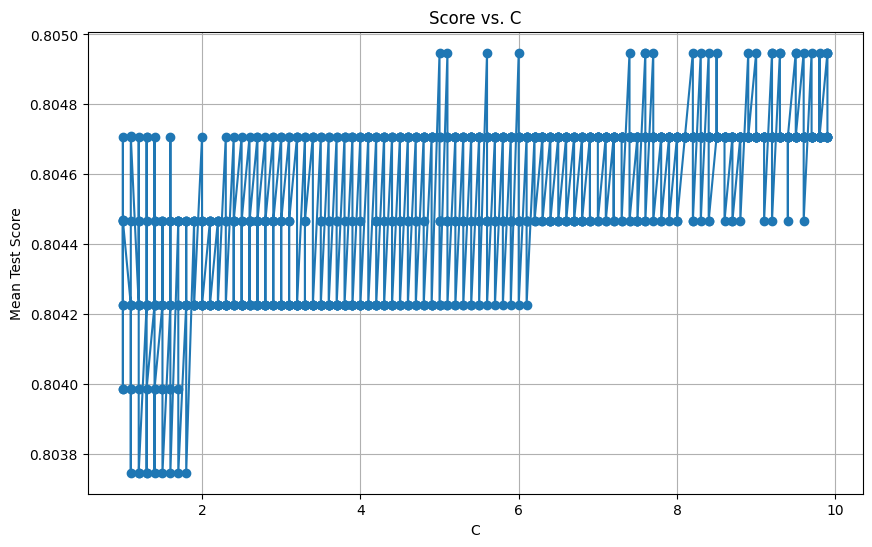

Best parameters: {'C': 5.0000000000000036, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}
Best Score: 0.8049476997130427


In [58]:
parameters = {'C': np.arange(1,10, 0.1), 
              'penalty': ['elasticnet'], 
              'solver': ['saga'],
              'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

result_elasticnet = best_feature_grid_search_visualization(X_train, y_train, parameters, model, result_elasticnet)

As the results are similar to the ones on the last approach we will consider lasso as the best regularization model for the same reasons.

##### Lasso

In [59]:
c = np.arange(result_lasso['C'] - 0.5, result_lasso['C'] + 0.5, 0.01)

parameters = {'C': c, 
              'penalty': ['l1'], 
              'solver': ['saga']}

best_feature_lasso = best_feature_grid_search(columns_name, X_train, y_train, parameters, model)

Best parameters: {'C': 0.22000000000000042, 'penalty': 'l1', 'solver': 'saga'}
Feature Coefficients:
                               Feature  Coefficient
0                             Altitude     3.193510
1                    Slope_Orientation    -0.139803
2                                Slope     0.000000
3         Horizontal_Distance_To_Water     0.000000
4           Vertical_Distance_To_Water    -0.529469
5      Horizontal_Distance_To_Roadways     0.119661
6                      Shadow_Index_9h     0.000000
7                     Shadow_Index_12h     0.081185
8                     Shadow_Index_15h     0.000000
9   Horizontal_Distance_To_Fire_Points     0.112394
10                    Soil_Type_Type_1     0.000000
11                   Soil_Type_Type_10    -0.532133
12                   Soil_Type_Type_11    -0.177552
13                   Soil_Type_Type_12     0.037830
14                   Soil_Type_Type_13     0.000000
15                   Soil_Type_Type_14     0.000000
16             


The best model used the penalty "l2" which utlizes the method ridge. We can observe that it gave more importance to the Altitude, Wilderness_Area_Area_1, Soil_Type_Type_2 and Vertical_Distance_To_Water. The first two features have a high correlation with the target column as previously observed. The importance of the second two were not expected since the correlation was low. Despite that this features can help differenciate between the type_3 and type_6 as seen in the bivariate analysis graphs. The majority of the other features were assigned an importance in similar ranges.

In [60]:
best_models_lr = {
    'Logistic Regression with Lasso': LogisticRegression(C=best_feature_lasso['C'],
                                                        penalty=best_feature_lasso['penalty'],
                                                        solver='saga')
}

#### Holdout Method

In [61]:
holdout_evaluation(data_results, best_models_lr, X, y, " dummies")

#### Cross Validation (K=5)

In [62]:
cross_validation_evaluation(data_results, best_models_lr, X_dummies, y_dummies, 5, " dummies")

#### Cross Validation (K=10)

In [63]:
cross_validation_evaluation(data_results, best_models_lr, X_dummies, y_dummies, 10, " dummies")

#### Leave One Out with Cross Validation

In [64]:
loocv_evaluation(data_results, best_models_lr, X_dummies, y_dummies, " dummies")

#### Bootstrap

In [65]:
bootstrap_evaluation(data_results, best_models_lr, X_dummies, y_dummies, 100, " dummies")

#### Results with Dummies

In [66]:
data_results

,Model,Method,Accuracy,Precision,Recall,F1,Std Dev,Confusion Matrix
0,Logistic Regression,Houldout,0.802694,0.803416,0.802694,0.799051,0.006209,"[[6391, 11, 90], [5, 2673, 2191], [59, 1160, 5..."
1,LDA,Houldout,0.799270,0.800241,0.799270,0.794730,0.005353,"[[6388, 12, 92], [1, 2596, 2272], [97, 1103, 5..."
2,QDA,Houldout,0.809484,0.811471,0.809484,0.807627,0.011984,"[[6320, 50, 122], [0, 2840, 2029], [25, 1169, ..."
3,Logistic Regression,Cross-Validation with 5,0.798822,0.799251,0.798822,0.794894,0.005952,"[[2130, 3, 27], [2, 870, 748], [15, 400, 1745]]"
4,LDA,Cross-Validation with 5,0.794444,0.794859,0.794444,0.789895,0.006700,"[[2126, 3, 31], [0, 851, 769], [31, 387, 1742]]"
5,QDA,Cross-Validation with 5,0.805724,0.807798,0.805724,0.803017,0.005172,"[[2107, 14, 39], [0, 908, 712], [7, 382, 1771]]"
6,Logistic Regression,Cross-Validation with 10,0.799663,0.800198,0.799663,0.795706,0.020797,"[[2129, 3, 28], [1, 874, 745], [17, 396, 1747]]"
7,LDA,Cross-Validation with 10,0.795118,0.796028,0.795118,0.790459,0.018763,"[[2125, 4, 31], [0, 849, 771], [30, 381, 1749]]"
8,QDA,Cross-Validation with 10,0.808923,0.811558,0.808923,0.806046,0.014526,"[[2106, 14, 40], [0, 912, 708], [8, 365, 1787]]"
9,Logistic Regression,LeaveOneOut,0.799158,0.799158,0.799158,0.799158,0.400630,"[[2130, 3, 27], [2, 875, 743], [19, 399, 1742]]"


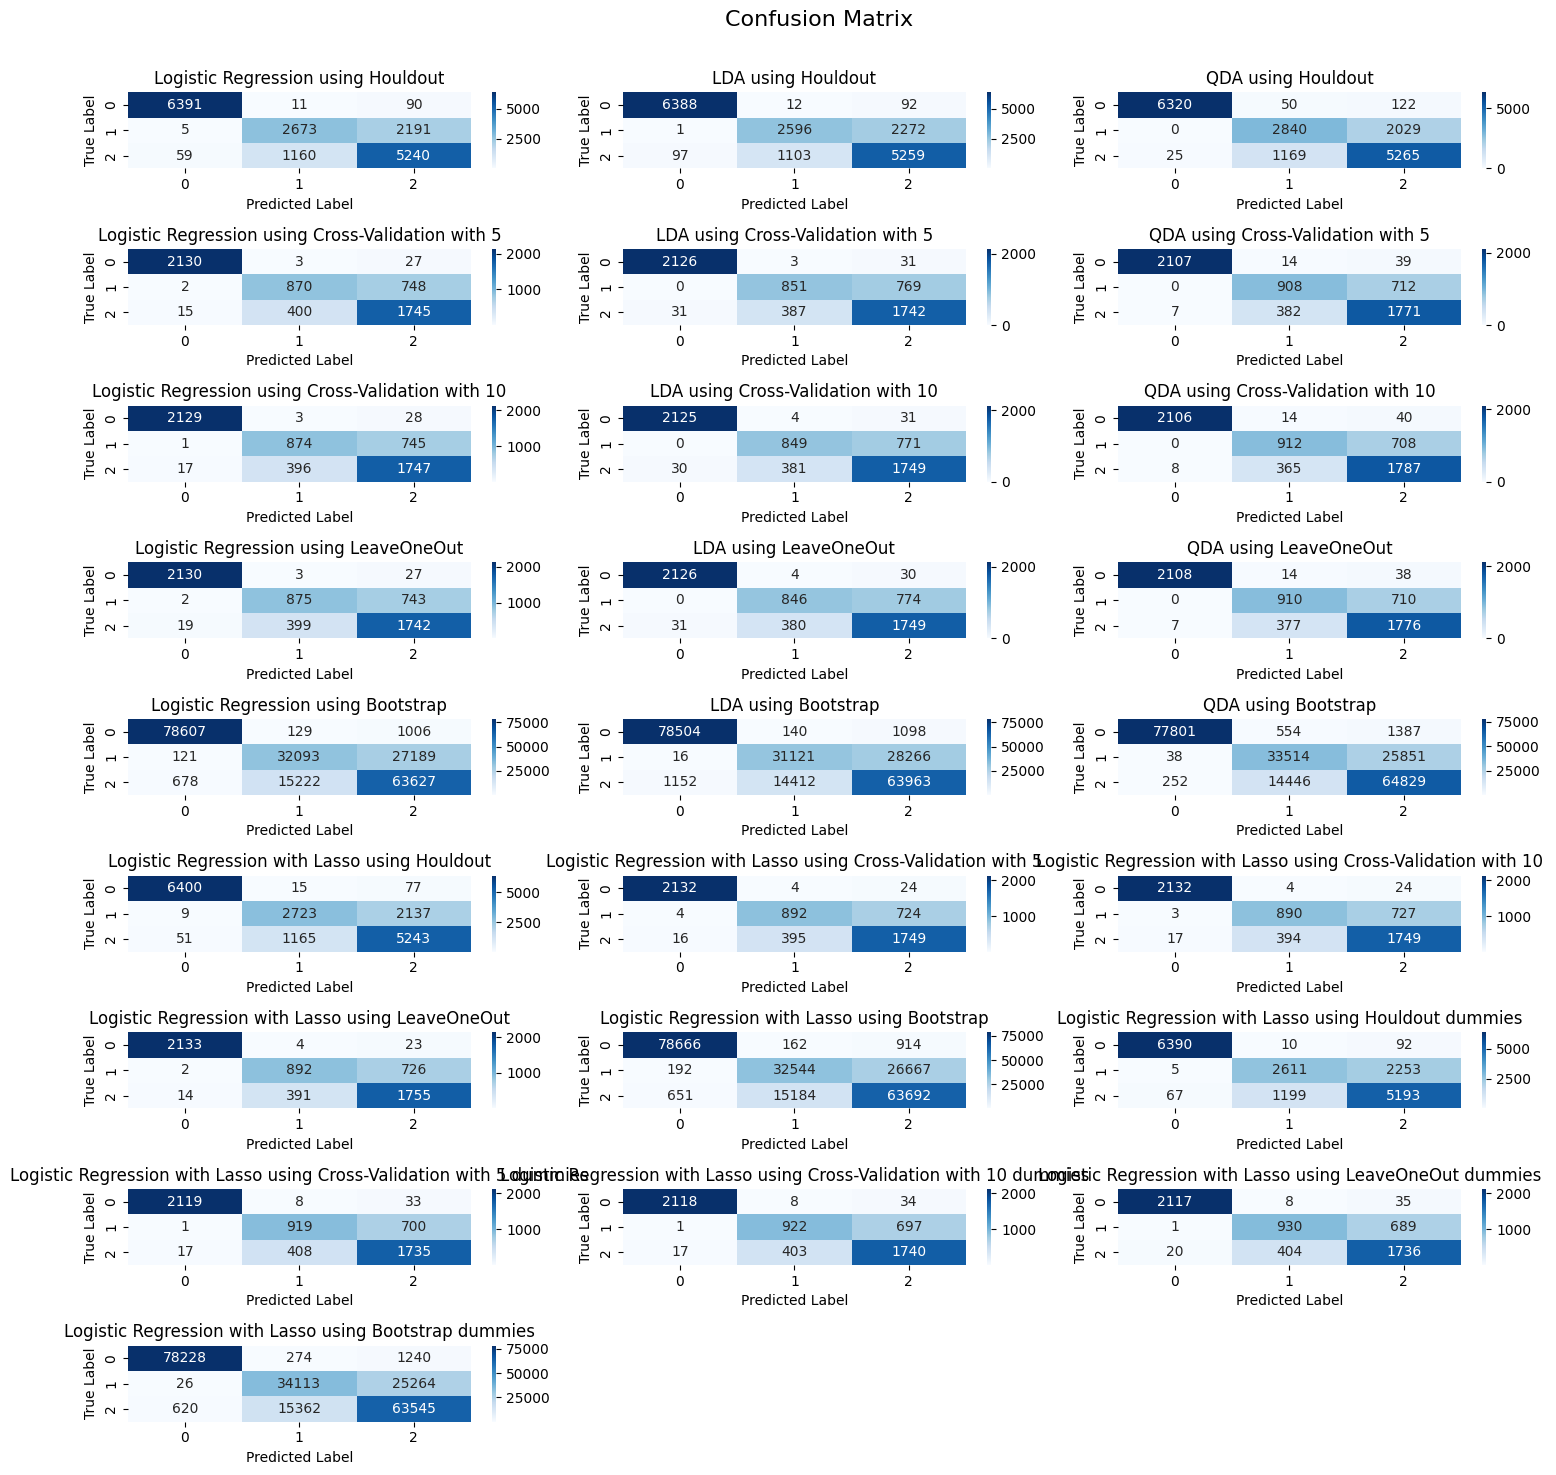

In [67]:
confusion_matrix_visualization(data_results, 'Confusion Matrix')

Using the regularization methods with dummies, we were able to get better results with holdout. It is visible that the amount mistaken samples between type_3 and type_6 is slighly smaller, justifying the better results.

We hope the results will improve even further with the use of more complex models that are able to capture the underlying correlation of the features.

In [72]:
# Saving the encoded data to a csv file

#df_encoded = encoded_data.drop(columns=['Id', 'Soil_Type', 'Wilderness_Area'])
df_encoded = encoded_data
df_encoded.to_csv('data/encoded_data.csv', index=False)

# Second Part

In [2]:
# Read the data from the csv files

data_encoded = pd.read_csv('data/encoded_data.csv')

# Remove the features selected by lasso

columns_to_remove = {
    "Horizontal_Distance_To_Water",
    "Shadow_Index_15h",
    "Slope",
    "Horizontal_Distance_To_Roadways",
    "Horizontal_Distance_To_Fire_Points"
}

df_encoded = data_encoded.drop(columns=columns_to_remove)

## GAMs

In [75]:
# Get the dummies of the Vegetation_Type column

df_types = pd.get_dummies(df_encoded['Vegetation_Type'], prefix='Is') * 1
df_encoded_label = pd.concat([df_encoded, df_types], axis=1)

In [76]:
# Create a dataframe for each type of vegetation

df_encoded_type1 = df_encoded_label.drop(columns=['Vegetation_Type','Vegetation_Type_Enc', 'Is_Type_3', 'Is_Type_6'])
df_encoded_type3 = df_encoded_label.drop(columns=['Vegetation_Type','Vegetation_Type_Enc', 'Is_Type_1', 'Is_Type_6'])
df_encoded_type6 = df_encoded_label.drop(columns=['Vegetation_Type','Vegetation_Type_Enc', 'Is_Type_1', 'Is_Type_3'])

In [77]:
# Shuffle the data

df_encoded_type1_shuffle = df_encoded_type1.sample(frac=1, random_state=42)
df_encoded_type3_shuffle = df_encoded_type3.sample(frac=1, random_state=42)
df_encoded_type6_shuffle = df_encoded_type6.sample(frac=1, random_state=42)

### Type 1

In [78]:
# Separate the data into features and target variable and convert them to numpy arrays

X = df_encoded_type1_shuffle.iloc[:, :-1]
y = df_encoded_type1_shuffle.iloc[:, -1]
X = X.to_numpy()
y = y.to_numpy()

In [79]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [89]:
# Creating the GAM model with splines for all the features

gam = LogisticGAM(s(0) + s(1) + s(2, n_splines=4) +  s(3, n_splines=4, lam=0) + s(4, n_splines=5, lam=0) + s(5) + s(6) + s(7) + s(8) + f(9) + f(10))
gam.fit(X_train, y_train)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + f(9) + f(10) + intercept,
   tol=0.0001, verbose=False)

ValueError: cannot create grid for intercept term

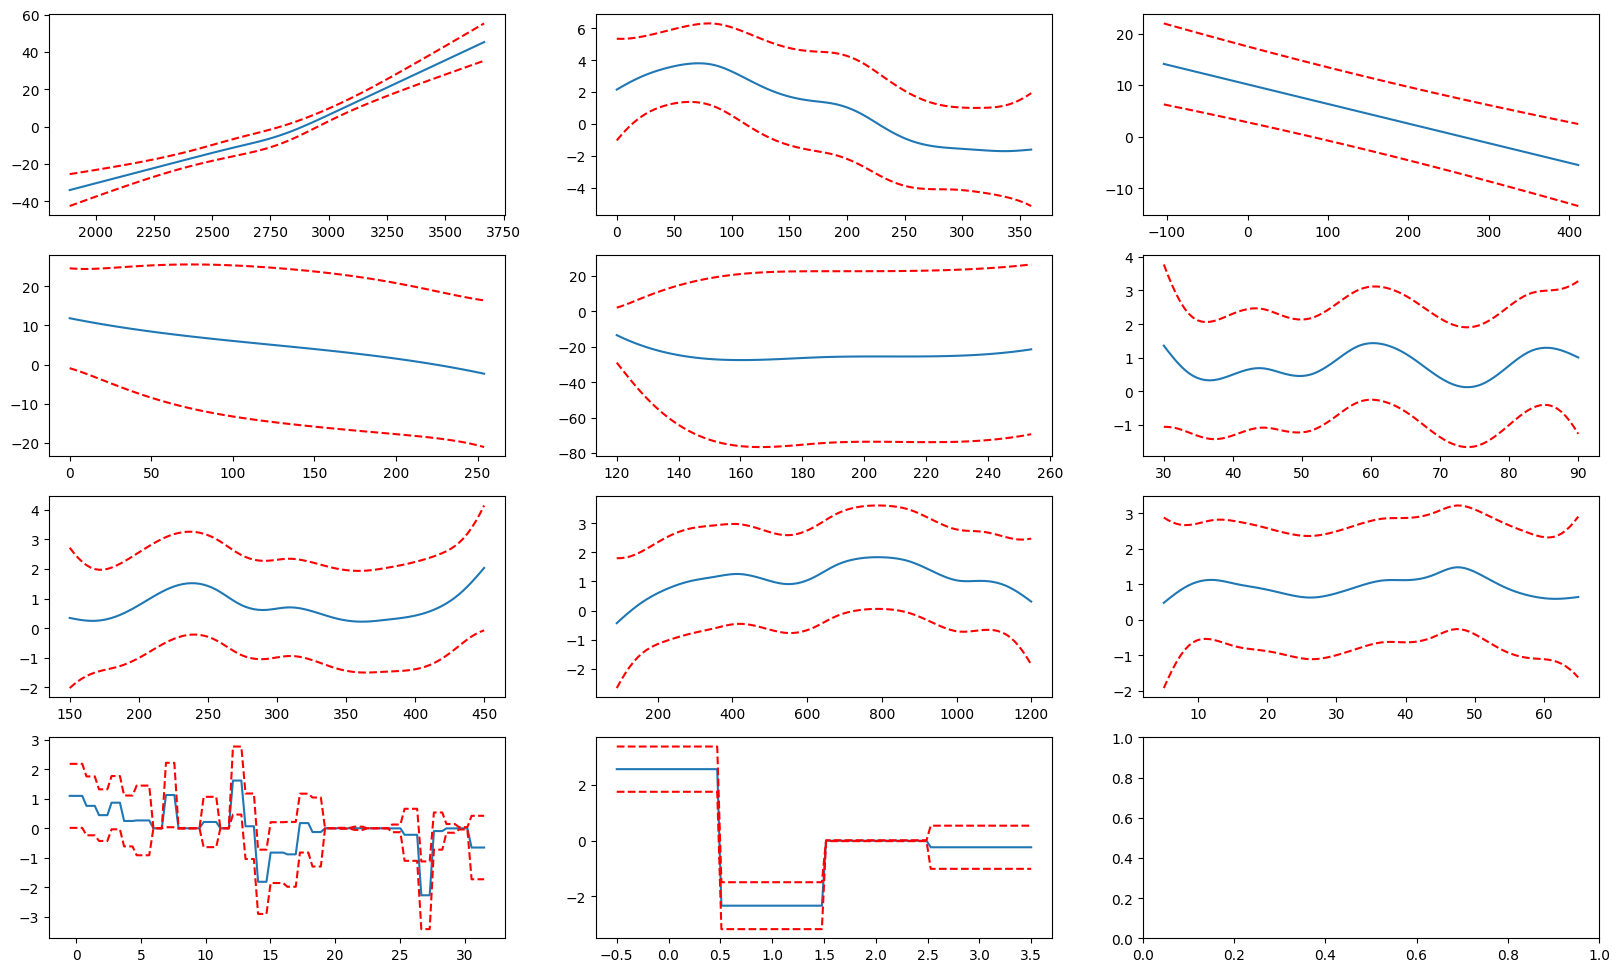

In [95]:
# Display the splines for each feature

fig, axs = plt.subplots(4, 3, figsize=(20, 4 * 3))
for i, ax in enumerate(axs.flat):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')

We can conclude that the model was able to create splines that capture the distribution of the features correctly. We will now test different configurations with only some features to see which one can get the best performance.

Since we could not conclude what are the best features to use with the model, we will use the insights of the previous data analysis we made. Earlier we concluded that the Type 1 vegetation is the most easily identifiable, so we will the regularization results to select the most important features. The best features were the Altitude, Vertical_Distance_To_Water, Soil_Type_Enc and Wilderness_Area_Enc. We will use these features to test the GAM model. For the numerical columns we will use splines and for the encoded columns we will use f terms.

In [96]:
# Define different configurations for splines and linear terms based on feature indices

spline_configs = [
    (s(0) + s(4) + s(4) + s(7) + f(9)),
    (s(0) + s(4) + s(4) + s(7) + s(5) + f(9)),
    (s(0) + s(1) + s(4) + s(4) + s(7) + f(9)),
    (s(0) + s(4) + s(4) + s(7) + f(9) + s(8)),
    (s(0) + s(4) + s(4) + s(7) + f(9) + s(3) + s(8)),
    (s(0) + s(4) + s(4) + s(7)  + s(8) + f(9)),
    (s(0) + s(4) + s(4) + s(7) + f(9) + s(8) + f(9)),
    (s(0) + s(4) + s(4) + s(7) + f(9) + s(3)  + s(5)),
    (s(0) + s(1) +  s(2, n_splines=4) + s(3, n_splines=4, lam=0) + s(4, n_splines=5, lam=0) + s(5) + s(6) + s(7) + s(8) + f(9)),
]

gam_gridsearch(X, y, spline_configs)

Best Model Configuration: s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + f(9) + intercept
Cross-validation F1 scores: [0.981651376146789, 0.9875, 0.9977220956719818, 0.972972972972973, 0.9767441860465116, 0.9954545454545455, 0.9917808219178083, 0.9832935560859188, 0.983451536643026, 0.9935760171306209]
Best Mean F1 Score: 0.9864
Standard deviation of F1 score: 0.0078


The best configuration did not include all the features, which makes the model simpler while still maintaining a good performance.

### Type 3

In [97]:
# Separate the data into features and target variable and convert them to numpy arrays

X = df_encoded_type3_shuffle.iloc[:, :-1]
y = df_encoded_type3_shuffle.iloc[:, -1]
X = X.to_numpy()
y = y.to_numpy()

In [98]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [99]:
# Creating the GAM model with splines for all the features

gam = LogisticGAM(s(0, n_splines=5) + s(1) + s(2, n_splines=4) + s(3) + l(7) + s(5) + s(6) + s(7) + s(8) + f(9) + f(10))
gam.fit(X_train, y_train)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + l(7) + s(5) + s(6) + s(7) + s(8) + f(9) + f(10) + intercept,
   tol=0.0001, verbose=False)

ValueError: cannot create grid for intercept term

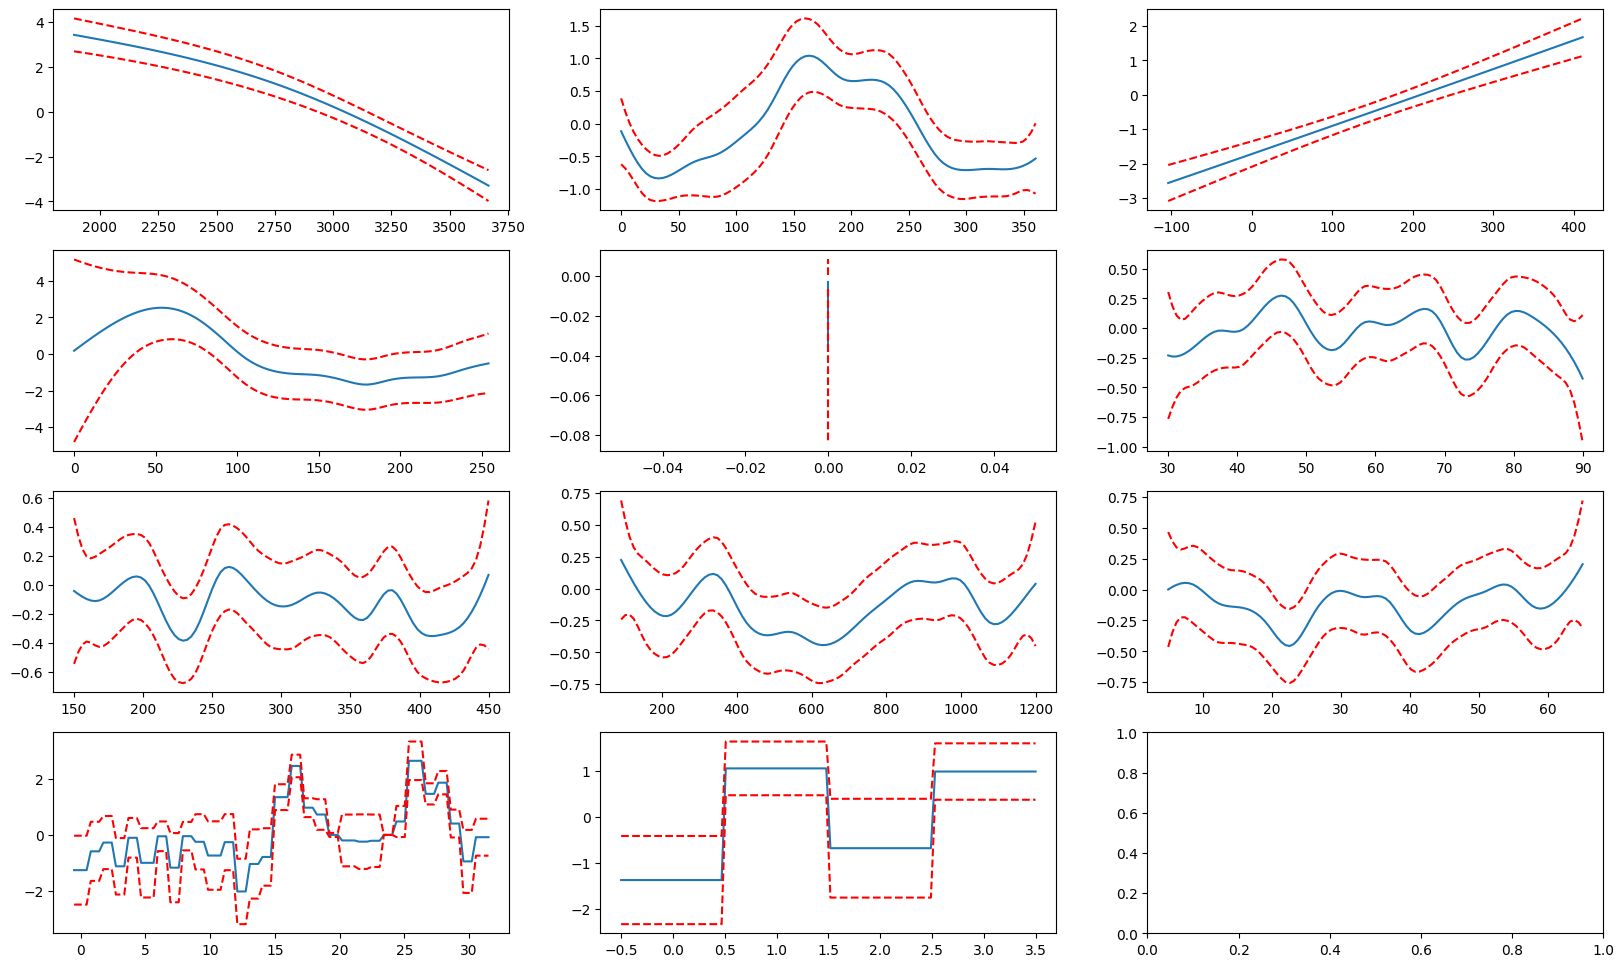

In [101]:
# Display the splines for each feature

fig, axs = plt.subplots(4, 3, figsize=(20, 4 * 3))
for i, ax in enumerate(axs.flat):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')

In this case the splines could also capture the distribution of the features correctly, although some of them did not adjust as well as the others. We will now test different configurations with only some features to see which one can get the best performance.

Since the type 3 and 6 are harder to distinguish, we will test the features that showed some difference between the classes in our analysis. The best features were the Altitude, Slope, Slope_Orientation, Shadow_Index_12h, Horizontal_Distance_To_Water, Vertical_Distance_To_Water and Shadow_Index_9h. We will use an approach similar to the last one.

In [102]:
# Define different configurations for splines and linear terms based on feature indices

spline_configs = [
    s(0, n_splines=5) + s(1) + s(4),
    s(0, n_splines=5) + s(2) + s(4),
    s(0, n_splines=5) + s(1) + s(4) + s(2, n_splines=4),
    s(0, n_splines=5) + s(1) + s(4) + s(3),
    s(0, n_splines=5) + s(2, n_splines=4) + s(3),
    s(0, n_splines=5) + s(3),
    s(0, n_splines=5) + s(2, n_splines=4) + s(4),
    s(0, n_splines=5) + s(4),
    s(0, n_splines=5) + s(1) + s(4) + s(2, n_splines=4) + s(3),
    s(0, n_splines=5) + s(1) + s(2, n_splines=4) + s(3) + l(7) + s(5) + s(6) + s(7) + s(8) + f(9)
]

gam_gridsearch(X, y, spline_configs)

Best Model Configuration: s(0) + s(1) + s(2) + s(3) + l(7) + s(5) + s(6) + s(7) + s(8) + f(9) + intercept
Cross-validation F1 scores: [0.6896551724137931, 0.6264150943396226, 0.5993031358885017, 0.6322188449848024, 0.6514657980456026, 0.6339622641509434, 0.6204819277108434, 0.6459627329192547, 0.6349206349206349, 0.6258503401360545]
Best Mean F1 Score: 0.6360
Standard deviation of F1 score: 0.0224


In this case the best configuration was the one that used all the features.

### Type 6

We will use the same terms as the type 3 since the features that showed some difference between the classes were the same.

In [103]:
# Separate the data into features and target variable and convert them to numpy arrays

X = df_encoded_type6_shuffle.iloc[:, :-1]
y = df_encoded_type6_shuffle.iloc[:, -1]
X = X.to_numpy()
y = y.to_numpy()

In [104]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [105]:
# Creating the GAM model with splines for all the features

gam = LogisticGAM(s(0, n_splines=5) + s(1) +   s(2, n_splines=4) +  s(3) + l(7) +   s(5) + s(6) + s(7) + s(8) + f(9) + f(10))
gam.fit(X_train, y_train)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + l(7) + s(5) + s(6) + s(7) + s(8) + f(9) + f(10) + intercept,
   tol=0.0001, verbose=False)

ValueError: cannot create grid for intercept term

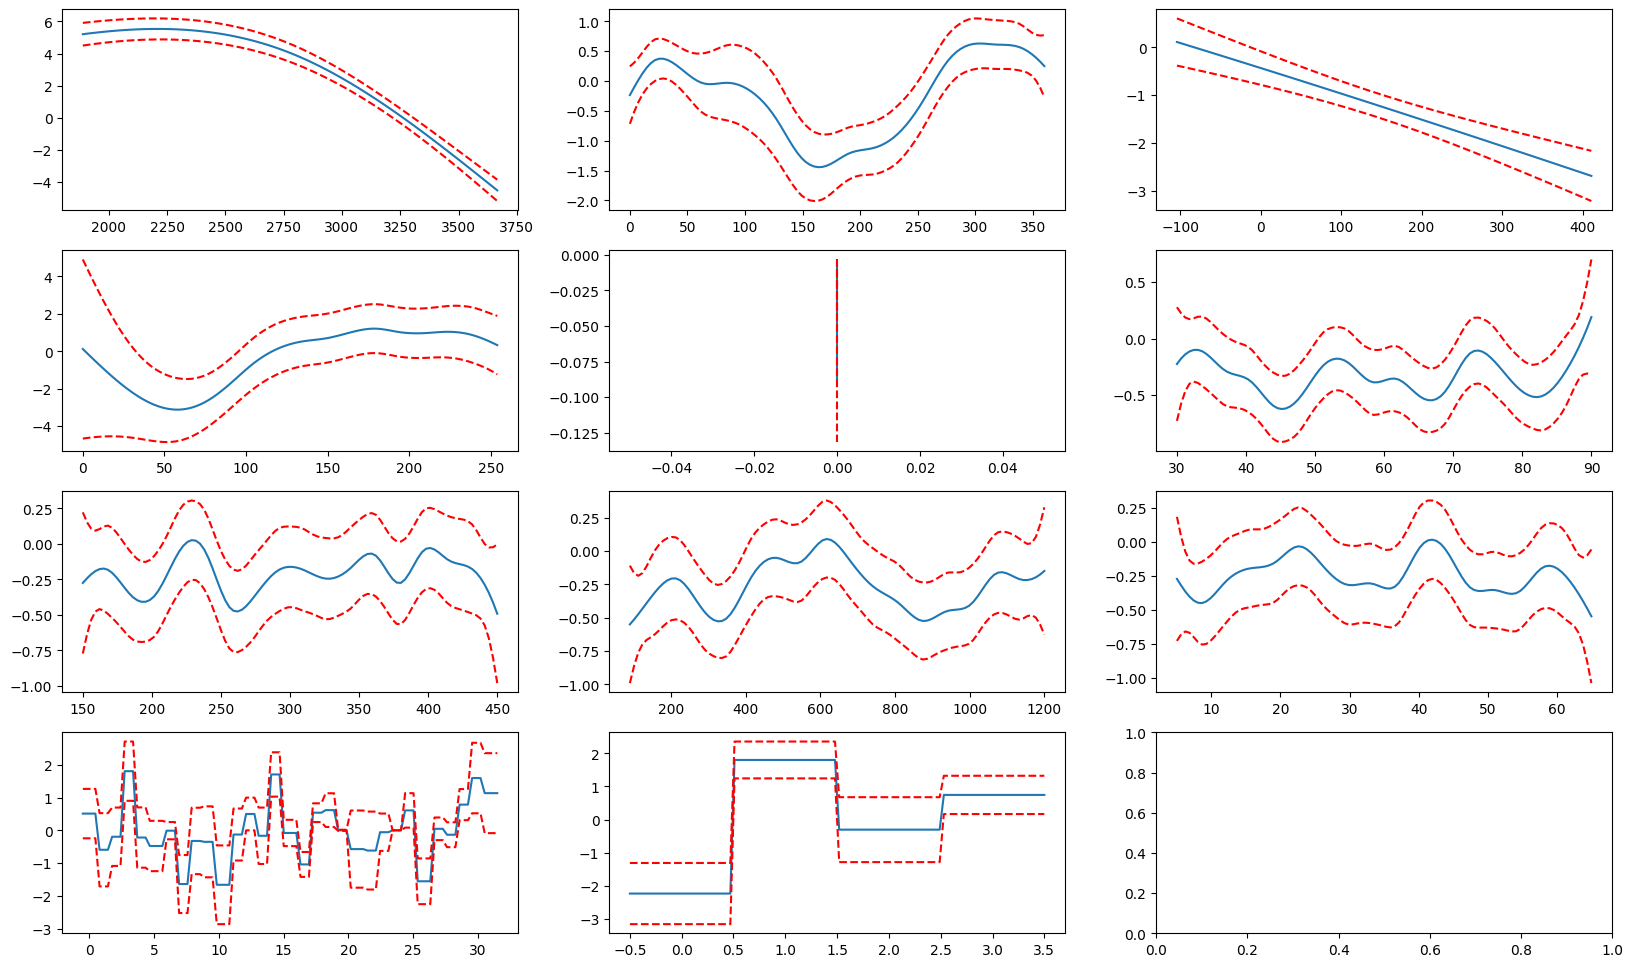

In [106]:
# Display the splines for each feature

fig, axs = plt.subplots(4, 3, figsize=(20, 4 * 3))
for i, ax in enumerate(axs.flat):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')

With the same configuration used to predict the type 3, we got similar results.

To predict the type 6 of the vegetation we will use the Altitude, Slope, Slope_Orientation, Shadow_Index_12h, Horizontal_Distance_To_Water, Vertical_Distance_To_Water and Shadow_Index_9h.

In [108]:
# Define different configurations for splines and linear terms based on feature indices

spline_configs = [
    s(0, n_splines=5) + s(1) + s(4),
    s(0, n_splines=5) + s(2) + s(4),
    s(0, n_splines=5) + s(1) + s(4) + s(2, n_splines=4),
    s(0, n_splines=5) + s(1) + s(4) + s(3),
    s(0, n_splines=5) + s(2, n_splines=4) + s(3),
    s(0, n_splines=5) + s(3),
    s(0, n_splines=5) + s(2, n_splines=4) + s(4),
    s(0, n_splines=5) + s(4),
    s(0, n_splines=5) + s(1) + s(4) + s(2, n_splines=4) + s(3),
    s(0, n_splines=5) + s(1) + s(2, n_splines=4) + s(3) + l(7) + s(5) + s(6) + s(7) + s(8) + f(9)
]

gam_gridsearch(X, y, spline_configs)

did not converge
did not converge
Best Model Configuration: s(0) + s(1) + s(2) + s(3) + l(7) + s(5) + s(6) + s(7) + s(8) + f(9) + intercept
Cross-validation F1 scores: [0.782608695652174, 0.75, 0.7444933920704846, 0.7152317880794702, 0.7292576419213974, 0.7663157894736842, 0.7287784679089027, 0.7117117117117117, 0.7533632286995515, 0.7388235294117647]
Best Mean F1 Score: 0.7421
Standard deviation of F1 score: 0.0210


In this case the best configuration was the one that used all the features.

Of the three models, predicting the type 1 vegetation was the easiest, while predicting the type 3 was the hardest. We decided to use the F1 score to evaluate the models since it is a good metric to balance precision and recall, as we want to avoid misclassifications between the classes. 

## Data processing

In [3]:
# Splitting the data

X = df_encoded.drop(columns=['Vegetation_Type','Vegetation_Type_Enc'])
y = df_encoded['Vegetation_Type_Enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Decision Tree

In [ ]:
X = df_encoded.iloc[:, :-1]
y = df_encoded.iloc[:, -1]
X = X.drop("Vegetation_Type", axis=1)
y = y.to_numpy()

First, we'll evaluate which features should be selected to maximize the performance of the decision tree

In [ ]:
base_features = ["Altitude", "Vertical_Distance_To_Water", "Shadow_Index_12h", "Rainfall_Winter"]

# Divide the dataset into the different splits of features
X1 = X[base_features]
X2 = X[base_features + ["Canopy_Density"]]
X3 = X[base_features + ["Slope_Orientation"]]
X4 = X[base_features + ["Wind_Exposure_Level"]]
X5 = X[base_features + ["Shadow_Index_9h", "Shadow_Index_15h"]]
X6 = X[base_features + ["Shadow_Index_15h", "Wind_Exposure_Level"]]
X7 = X[base_features + ["Wind_Exposure_Level"]]
X8 = X[base_features + ["Shadow_Index_9h", "Shadow_Index_15h", "Canopy_Density"]]

X_datasets = {
    "X": X,
    "X1": X1,
    "X2": X2,
    "X3": X3,
    "X4": X4,
    "X5": X5,
    "X6": X6,
    "X7": X7,
    "X8": X8,
}

In [ ]:
decision_tree(X_datasets, y)

With this we can see that the original X dataset provides us with the best score, and considering the difference between the best and second best score is relatively significant, we will move forward with the X dataset.

In [ ]:
# Define the grid of parameters to provide to the decision tree classifier

params_grid = {
    'max_depth': np.arange(1, 100, 1),
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

decision_tree_grid_search(X, y, params_grid)

## Random Forest

In [113]:
# Define the baseline random forest and evaluate

rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)
print("Training accuracy:", accuracy_score(y_train, y_pred_train))
print("Testing accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 1.0
Testing accuracy: 0.8428731762065096
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       670
           1       0.74      0.68      0.71       482
           2       0.76      0.82      0.79       630

    accuracy                           0.84      1782
   macro avg       0.83      0.83      0.83      1782
weighted avg       0.84      0.84      0.84      1782


In [114]:
# Get the depth values of the trees

depths = [tree.tree_.max_depth for tree in rf_model.estimators_]
print("Maximun depth:",max(depths))
print("Average depth:",int(sum(depths)/len(depths)))

Maximun depth: 32
Average depth: 24


In [115]:
# Get the leaf nodes of the trees

leaf_nodes = [tree.tree_.n_leaves for tree in rf_model.estimators_]
print("Maximum leaf nodes:", max(leaf_nodes))
print("Average leaf nodes:", sum(leaf_nodes) / len(leaf_nodes))

Maximum leaf nodes: 521
Average leaf nodes: 458.8


As we can see the model overfitted during training. This is due to the depth of the tree being a very large number. During the hyperparameter tuning we will choose attributes that minimize the size of the tree, avoiding overfitting.

In [116]:
# Define the grid of parameters to provide to the random forest

param = {
        'n_estimators': [50,100],
        'max_depth': np.arange(10,15,1),
        'max_leaf_nodes': [100, 150, 200],
        'max_features': ['auto', 'sqrt']
}

In [117]:
# Get the best combination of parameters using grid search

best_random_forest(X_train, y_train, param)

Best parameters {'max_depth': 14, 'max_features': 'sqrt', 'max_leaf_nodes': 200, 'n_estimators': 100}


In [118]:
# Define the model with the best parameters and evaluating

random_forest = RandomForestClassifier(max_depth=14, max_features='sqrt', max_leaf_nodes=150, n_estimators=100)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

y_pred_train = random_forest.predict(X_train)
print("Training accuracy:", accuracy_score(y_train, y_pred_train))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy: 0.9463684463684464
Accuracy: 0.8361391694725028
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       670
           1       0.76      0.63      0.69       482
           2       0.74      0.85      0.79       630

    accuracy                           0.84      1782
   macro avg       0.83      0.82      0.82      1782
weighted avg       0.84      0.84      0.83      1782


In [119]:
# Get the coefficients of importance of each feature

get_feature_importances_text(X.columns, random_forest.feature_importances_)

Feature Importances:
- Altitude: 0.388
- Soil_Type_Enc: 0.229
- Wilderness_Area_Enc: 0.093
- Shadow_Index_9h: 0.055
- Vertical_Distance_To_Water: 0.052
- Slope_Orientation: 0.052
- Shadow_Index_12h: 0.042
- Wind_Exposure_Level: 0.023
- Rainfall_Summer: 0.023
- Canopy_Density: 0.022
- Rainfall_Winter: 0.022


As we can see the most important features were the altitude,... The results are coherent with the analysis made earlier since these features showed a good distinction of its values among the different classes.
The ridge and lasso also showed that these features have high importance.

## SVMs

In [4]:
from sklearn.svm import SVC

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
    svm = SVC(kernel=kernel)
    svm.fit(X_train, y_train)
    score = svm.score(X_test, y_test)
    print(f'Kernel: {kernel} - Score: {score}')

Kernel: linear - Score: 0.7536475869809203
Kernel: poly - Score: 0.7149270482603816
Kernel: rbf - Score: 0.7143658810325477
Kernel: sigmoid - Score: 0.038159371492704826


In [5]:
from sklearn.model_selection import GridSearchCV

svm = SVC()

param_grid = [
    {'kernel': ['linear'], 'C': [0.01,0.1,0.5]}
]

search = GridSearchCV(svm, param_grid = param_grid, scoring = 'accuracy', cv = 5)
search.fit(X_train, y_train)

print(search.best_params_)

{'C': 0.1, 'kernel': 'linear'}


In [6]:
svm = SVC()

param_grid = [
    {'kernel': ['rbf'], 'C': [0.01,0.1,0.5], 'gamma': ['scale', 'auto']}
]

search = GridSearchCV(svm, param_grid = param_grid, scoring = 'accuracy', cv = 5)
search.fit(X_train, y_train)

print(search.best_params_)

{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
svm = SVC()

param_grid = [
    {'kernel': ['poly'], 'C': [0.01,0.1]}
]

search = GridSearchCV(svm, param_grid = param_grid, scoring = 'accuracy', cv = 5)
search.fit(X_train, y_train)

print(search.best_params_)

In [ ]:
svm = SVC()

param_grid = [
    {'kernel': ['sigmoid'], 'C': [0.01,0.1,0.5], 'gamma': ['scale', 'auto']}
]

search = GridSearchCV(svm, param_grid = param_grid, scoring = 'accuracy', cv = 5)
search.fit(X_train, y_train)

print(search.best_params_)

## PCA

In [ ]:
from sklearn.decomposition import PCA

scaler = StandardScaler(with_std=True,
                        with_mean=True)

X = data_encoded.drop(columns=['Vegetation_Type','Vegetation_Type_Enc'])
y = data_encoded['Vegetation_Type_Enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

pca = PCA(n_components=None)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()

cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components_95 = (cumulative_variance >= 0.95).argmax() + 1 
print(f"Number of components explaining 95% variance: {n_components_95}")

pca_final = PCA(n_components=n_components_95)
X_train_pca_final = pca_final.fit_transform(X_train_scaled)
X_test_pca_final = pca_final.transform(X_test_scaled)

print(f"Original number of features: {X.shape[1]}")
print(f"Reduced number of features: {n_components_95}")